# **Stackoverflow Analysis**

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time
import re
from wordcloud import WordCloud
import spacy
from spacy.lang.en.examples import sentences
from bs4 import BeautifulSoup
import collections
import itertools
import math
import networkx as nx
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

In [2]:
import datetime as dt
from tqdm import tqdm
from operator import itemgetter

In [ ]:
#!python -m spacy download en_core_web_md

## **Functions**

In [2]:
def tag_extraction(db_col, tag_dict):
    """
    the function takes a column of a db and an
    empty dictionary
    """
    for item in db_col:
        tag = item.split('|')
        for t in tag:
            if t not in tag_dict:
                tag_dict[t] = 1
            else: 
                temp = tag_dict[t]
                temp +=1
                tag_dict[t] = temp

    return tag_dict

In [3]:
def tag_trend(df, tag_dict, tags='tags', year_month='post_creation_year_month'):
    '''
    it returns a dictionary where each key is a tag and its value
    is a dictionary where the keys are year-month and the values are 
    the counts of posts that have that tag
    '''  
    for index in df.index:
        tag = df[tags][index].split('|')
        time = df[year_month][index]
        for t in tag:
            if t not in tag_dict:
                tag_dict[t] = {time: 1}
            else: 
                if time not in tag_dict[t]:
                    tag_dict[t][time] = 1
                else:
                    temp = tag_dict[t][time]
                    temp +=1
                    tag_dict[t][time]= temp
    return tag_dict



In [4]:
tag_pattern = r'tensorflow|keras|^pyspark|^pytorch|scikit-learn|^spacy$|gensim|sklearn|recommender-systems|recommendation-engine'

reg_pattern = re.compile(tag_pattern,re.IGNORECASE)

#tag_sub_pattern = r'tensorflow|keras'

#reg_sub_pattern = re.compile(tag_sub_pattern,re.IGNORECASE)

def tag_presence(db_col,reg_pattern):
    '''
    db_col: column of the db
    reg_pattern: result of the re.compile for a specific tag_pattern (case insensitve)
    '''
    if reg_pattern.search(db_col):
        return(1)
    else:
        return(0)    

In [5]:
#nlp = spacy.load("en_core_web_md")

#define function to lowercase, lemmatizes, removes punctuation, remove stop word
def is_token_allowed(token):
    '''
        Only allow valid tokens which are not stop words, 
        punctuation symbols, numbers or determiners.
    '''
    if token.is_stop or token.is_punct or token.is_space or token.pos_=='NUM' or token.pos_=='DET' or token.pos_=='SYM':
        return False
    return True


#take the lowercase lemma form of a token
def preprocess_token(token):
    '''
       Reduce token to its lowercase lemma form
    '''
    return token.lemma_.strip().lower()


#return a lemma dict from the title of the posts
def get_lemma_dict(db_col, lemma_dict):
    ''' 
      from a text colum return a dictionary of lemmas (lower case
      and no punctuation or numbers)
    '''
    for desc in db_col:
        desc_doc = nlp(desc)
        complete_filtered_tokens = [preprocess_token(token) for token in desc_doc if is_token_allowed(token)]
        for lemma in complete_filtered_tokens:
            if lemma not in lemma_dict.keys():
                lemma_dict[lemma] = 1
            else:
                lemma_dict[lemma] +=1
    return lemma_dict

In [6]:
# print wordcloud
def plt_wc(word_dict_sorted):
    wc = WordCloud(random_state = 42, 
              background_color = "white", 
              contour_width=4,
              contour_color='black',
               width=800, 
               height=400,
              max_words=1000).generate_from_frequencies(word_dict_sorted)

    plt.figure(figsize=[15,15])
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

In [7]:
def tag_trend_hierarchy(df, tag_dict, tag_name, tags='tags', year_month='post_creation_year_month'):
    '''
    considering a tag the function focuses only on post where the tag is available and 
    returns all the tags available together with the one we are interested in.
    It returns a dictionary where each key is a tag and its value
    is a dictionary where the keys are year-month and the values are 
    the counts of posts that have that tag
    '''  
    for index in df.index:
        tag_check = ' ' + ' '.join(df[tags][index].split('|')) + ' '
        tag = df[tags][index].split('|')
        time = df[year_month][index]
        if re.search(tag_name,tag_check):
            for t in tag:
                if t not in tag_dict:
                    tag_dict[t] = {time: 1}
                else: 
                    if time not in tag_dict[t]:
                        tag_dict[t][time] = 1
                    else:
                        temp = tag_dict[t][time]
                        temp +=1
                        tag_dict[t][time]= temp
                
    return tag_dict     

## **BigQuery Connection**

You need to create a service account for Bigquery and save the corresponding credentials

In [9]:
key_path = 'path_to your_credentials'

credentials = service_account.Credentials.from_service_account_file(key_path)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

In [10]:
client = bigquery.Client(credentials=credentials)

### **Dry Run**

In [11]:
job_config_dry = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)

query = """
SELECT 
q.Id,
title,
--body,
--post_type_id,
score,
view_count,
tags,
EXTRACT (DATE FROM q.creation_date AT TIME ZONE "UTC") as post_creation_date,
answer_count,
accepted_answer_id,
comment_count,
favorite_count,
owner_user_id,
EXTRACT (DATE FROM u.creation_date AT TIME ZONE "UTC") as user_creation_date,
u.reputation
FROM `bigquery-public-data.stackoverflow.posts_questions` as q
LEFT JOIN 
 `bigquery-public-data.stackoverflow.users`  as u
ON q.owner_user_id= u.Id
"""
query_job_dry = client.query(query, job_config=job_config_dry)  # Make an API request.

# A dry run query completes immediately.
print("This query will process {} MiB.".format(query_job_dry.total_bytes_processed/1000000))

This query will process 3656.374924 MiB.


### **Extraction**

In [257]:
sql= """
SELECT 
q.Id,
title,
--body,
--post_type_id,
score,
view_count,
tags,
EXTRACT (DATE FROM q.creation_date AT TIME ZONE "UTC") as post_creation_date,
answer_count,
accepted_answer_id,
comment_count,
favorite_count,
owner_user_id,
EXTRACT (DATE FROM u.creation_date AT TIME ZONE "UTC") as user_creation_date,
u.reputation
FROM `bigquery-public-data.stackoverflow.posts_questions` as q
LEFT JOIN 
 `bigquery-public-data.stackoverflow.users`  as u
ON q.owner_user_id= u.Id
"""


In [258]:
query_job = client.query(sql, job_config=None)

In [260]:
query_job.running()

False

In [261]:
start_time = time.time()
df = query_job.to_dataframe()
end_time = time.time()

In [262]:
end_time-start_time

571.6934337615967

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22306171 entries, 0 to 22306170
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Id                        int64  
 1   title                     object 
 2   score                     int64  
 3   view_count                int64  
 4   tags                      object 
 5   post_creation_date        object 
 6   answer_count              int64  
 7   accepted_answer_id        float64
 8   comment_count             int64  
 9   favorite_count            float64
 10  owner_user_id             float64
 11  user_creation_date        object 
 12  reputation                float64
 13  post_creation_year        int64  
 14  post_creation_year_month  object 
dtypes: float64(4), int64(6), object(5)
memory usage: 2.5+ GB


# **EDA**

In [138]:
df.head()

Id                                              title  score  \
0  29127606  Polymorphic Associations undefined method 'con...      1   
1  28966876                    CSS or Javascript: Custom popup     -4   
2  69626958  Compiling glibc and adding a function to string.h      1   
3  58633368     Running an Asyncio loop within a time interval      3   
4  58600214  HEVC VIdeo Extensions keep taking memory until...      1   

   view_count                                               tags  \
0         363  ruby-on-rails|ruby|undefined|polymorphic-assoc...   
1          82                                javascript|html|css   
2          79                             c|linux|makefile|glibc   
3        1715                              python|python-asyncio   
4         347  windows|memory-management|uwp|ms-media-foundat...   

  post_creation_date  answer_count  accepted_answer_id  comment_count  \
0         2015-03-18             1          29134279.0             11   
1         2015-03-10             2          28966995.0             13   
2         2021-10-19             0                 NaN             12   
3         2019-10-30             2          58634302.0             11   
4         2019-10-29             0                 NaN             12   

   favorite_count  owner_user_id user_creation_date  reputation  \
0             NaN      4383667.0         2014-12-21      2618.0   
1             NaN      1493868.0         2012-07-01      5422.0   
2             2.0      4808760.0         2015-04-20      3340.0   
3             1.0      4701426.0         2015-03-23      1566.0   
4             1.0     12032781.0         2019-09-06        23.0   

   post_creation_year post_creation_year_month  
0                2015                  2015-03  
1                2015                  2015-03  
2                2021                  2021-10  
3                2019                  2019-10  
4                2019                  2019-10

### **Extract year and year-month and add the column**

In [265]:
df['post_creation_year']=pd.DatetimeIndex(df['post_creation_date']).year

In [266]:
df['post_creation_year_month']=pd.DatetimeIndex(df['post_creation_date']).to_period('M')
df['post_creation_year_month']= df['post_creation_year_month'].astype(str)

In [13]:
df.head(2)

Id                                              title  score  \
0  29127606  Polymorphic Associations undefined method 'con...      1   
1  28966876                    CSS or Javascript: Custom popup     -4   

   view_count                                               tags  \
0         363  ruby-on-rails|ruby|undefined|polymorphic-assoc...   
1          82                                javascript|html|css   

  post_creation_date  answer_count  accepted_answer_id  comment_count  \
0         2015-03-18             1          29134279.0             11   
1         2015-03-10             2          28966995.0             13   

   favorite_count  owner_user_id user_creation_date  reputation  \
0             NaN      4383667.0         2014-12-21      2618.0   
1             NaN      1493868.0         2012-07-01      5422.0   

   post_creation_year post_creation_year_month  
0                2015                  2015-03  
1                2015                  2015-03

In [268]:
df['post_creation_date'] = df['post_creation_date'].astype(str)
df['user_creation_date']= df['user_creation_date'].astype(str)

In [1]:
### save to pickle
#df.to_pickle('df_all_pickle.pkl', compression = None)

#####read from pickle saved (only if you already ran the notebook and you saved the pkl)
#df = pd.read_pickle('./save_dataset/df_all_pickle.pkl')

C:\Users\Eva\AppData\Local\Temp/ipykernel_10500/4077299280.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  yp.set_yticklabels(yp.get_yticks() ,fontsize=15);


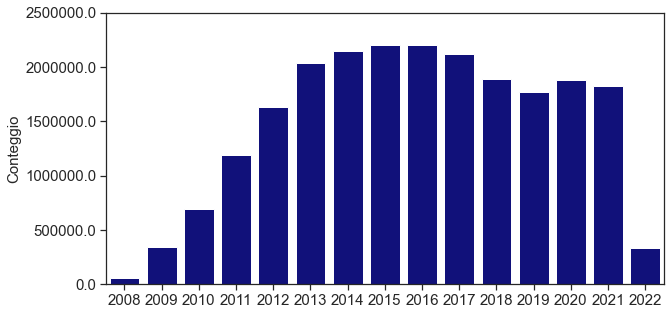

In [314]:
fig =plt.figure(figsize=(10,5))
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

yp=sns.countplot(data = df, x = 'post_creation_year', color = 'darkblue')
yp.set_ylim(0,2.5e6)
yp.set(xlabel=None) 
yp.set(xlabel=None) 
yp.set_xticklabels(yp.get_xticklabels(), fontsize=15)
yp.set_ylabel('Conteggio',fontsize= 15)
yp.set_yticklabels(yp.get_yticks() ,fontsize=15);
fig.savefig('./figure/post_answers.png', bbox_inches = "tight")

C:\Users\Eva\AppData\Local\Temp/ipykernel_10500/3736948052.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ypu.set_yticklabels(ypu.get_yticks() ,fontsize=15);
C:\Users\Eva\AppData\Local\Temp/ipykernel_10500/3736948052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ypu.set_yticklabels(ypu.get_yticks() ,fontsize=15);


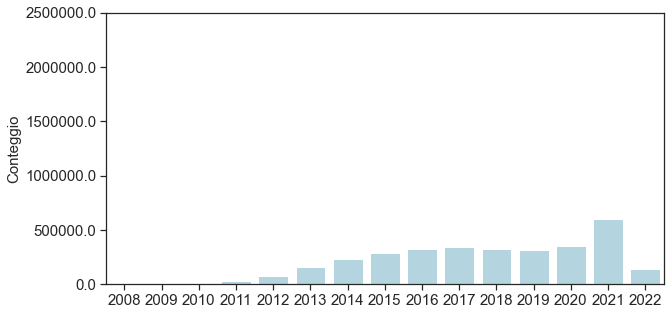

In [315]:
fig =plt.figure(figsize=(10,5))
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

ypu=sns.countplot(data = df[df['answer_count']==0], x = 'post_creation_year', color = 'lightblue')
ypu.set_ylim(0,2.5e6)
ypu.set(xlabel=None) 
ypu.set_xticklabels(ypu.get_xticklabels(), fontsize=15)
ypu.set(ylabel=None) 
ypu.set_ylabel('Conteggio',fontsize= 15)
ypu.set_yticklabels(ypu.get_yticks() ,fontsize=15);
fig.savefig('./figure/post_0_answers.png', bbox_inches = "tight")

C:\Users\Eva\AppData\Local\Temp/ipykernel_8936/304456881.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks() ,fontsize=15)


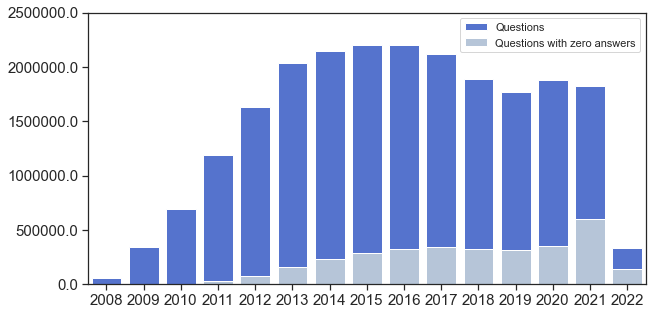

In [67]:
fig =plt.figure(figsize=(10,5))
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

b=sns.countplot(data = df, x = 'post_creation_year', color = 'royalblue')
b=sns.countplot(data = df[df['answer_count']==0], x = 'post_creation_year', color = 'lightsteelblue')
b.set_ylim(0,2.5e6)
b.set(xlabel=None) 
b.set_xticklabels(b.get_xticklabels(), fontsize=15)
b.set(ylabel=None) 
#b.set_ylabel('Conteggio',fontsize= 15)
b.set_yticklabels(b.get_yticks() ,fontsize=15)
plt.legend(labels=["Questions","Questions with zero answers"])
#plt.legend(labels=["Domande","Domande con zero risposte"])
#fig.savefig('./figure/post_all_together.png', bbox_inches = "tight")
fig.savefig('./pycon/post_all_together.png', bbox_inches = "tight")

### **Answer Count**

(0.0, 10.0)

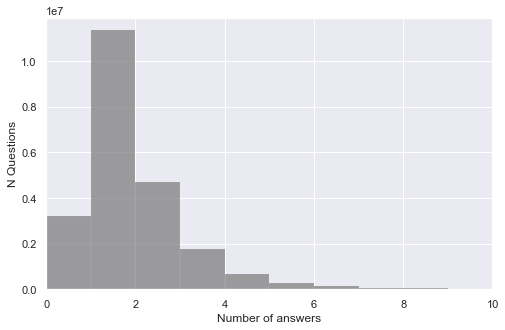

In [21]:
#histogram with x-axis limit set to 10 since the distribution of answers has a long tail - max is 518-
sns.set(rc={'figure.figsize':(8,5)})
h= sns.histplot(data = df, x="answer_count",binwidth=1, color='grey')
h.set( xlabel = "Number of answers", ylabel = "N Questions");
h.set_xlim(0,10)

In [22]:
print(f'The percentage of question with 0 answers is: {(df.Id[df.answer_count==0].count()/df.Id.count())}')
print(f'The percentage of question with 1 answers is: {(df.Id[df.answer_count==1].count()/df.Id.count())}')
print(f'The percentage of question with >1 answers is: {(df.Id[df.answer_count>1].count()/df.Id.count())}')

The percentage of question with 0 answers is: 0.14334988286425313
The percentage of question with 1 answers is: 0.5080548337946481
The percentage of question with >1 answers is: 0.34859528334109874


50% of questions has 1 answer, 14% has 0 answer

[Text(0.5, 0, 'Number of answers'), Text(0, 0.5, '% Questions')]

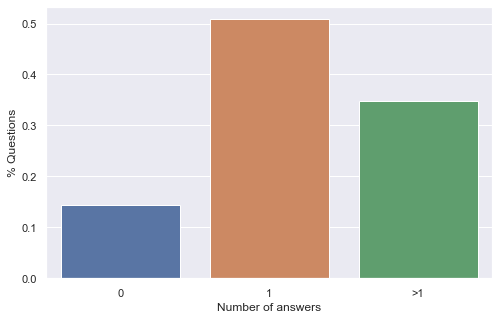

In [23]:
cat = ['0', '1', '>1']
answ_distr = [(df.Id[df.answer_count==0].count()/df.Id.count()),(df.Id[df.answer_count==1].count()/df.Id.count()),
              (df.Id[df.answer_count>1].count()/df.Id.count())]

sns.set(rc={'figure.figsize':(8,5)})
p = sns.barplot(x = cat, y = answ_distr)
p.set( xlabel = "Number of answers", ylabel = "% Questions")

In [33]:
print(df.Id.nunique())
print(df.Id[df.answer_count==1].count()/df.Id.count())
print(df.Id[df.answer_count==2].count()/df.Id.count())
print(df['answer_count'].max())

print(df.Id[df.answer_count==1].count()/df.Id[df.answer_count>0].count())
print(df.Id[df.answer_count==2].count()/df.Id[df.answer_count>0].count())

22306171
0.5080548337946481
0.21041096654374253
518
0.5930715745342512
0.24562065928066673


In [63]:
print(df.Id[(df.answer_count==0) &((df.post_creation_year==2018))].count()/df.Id[df.post_creation_year==2018].count())
print(df.Id[(df.answer_count==0) &((df.post_creation_year==2019))].count()/df.Id[df.post_creation_year==2019].count())
print(df.Id[(df.answer_count==0) &((df.post_creation_year==2020))].count()/df.Id[df.post_creation_year==2020].count())
print(df.Id[(df.answer_count==0) &((df.post_creation_year==2021))].count()/df.Id[df.post_creation_year==2021].count())

0.17386030580082495
0.17757347311584323
0.18972157629210298
0.3280744602879927


In [67]:
print(df.Id[((df.answer_count==0) &(df.post_creation_year==2018))].count())
print(df.Id[((df.answer_count==0) &(df.post_creation_year==2019))].count())

328810
314269


Text(0.5, 0, '')

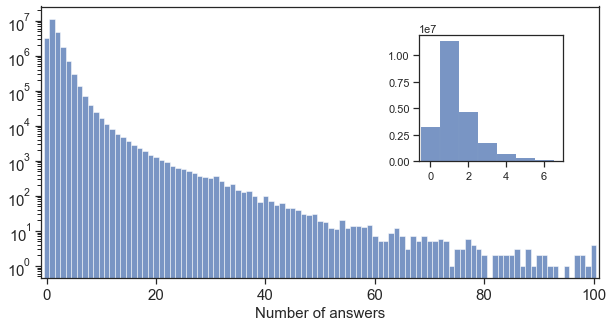

In [70]:

fig, ax =plt.subplots()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

sns.histplot(data = df[df['answer_count']<=100], x="answer_count", color = 'b',stat='count', bins=100, discrete=True, ax = ax)
ax.set_yscale("log")
ax.set_ylabel('')
#ax.set_yticklabels(hc.get_yticks() ,fontsize=15)
ax.set_xlabel('Number of answers', fontsize=15)
#ax.set_xlabel('Numero risposte', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlim([-1,101])

ax2 = plt.axes([0.65, 0.45, .20, .35])
sns.histplot(data = df, x="answer_count",binwidth=1, discrete = True, ax=ax2)
ax2.set_xlim([-0.6,7])
ax2.set_ylabel('')
ax2.set_xlabel('')



In [71]:
#fig.savefig('./figure/collage.png', bbox_inches = "tight")
fig.savefig('./pycon/collage.png', bbox_inches = "tight")

In [43]:
df[['answer_count', 'Id']].groupby(by='answer_count').count().to_csv(r'histogram.csv')

Considering only questions with 0 answer, do they have any comment?

Only 20% of questions with 0 answer has 0 comments, around 70% has at least 2 comments or mote

In [24]:
print(f'There are {df.Id[df.answer_count==0].count()} questions with 0 answer')

There are 3197587 questions with 0 answer


(0.0, 20.0)

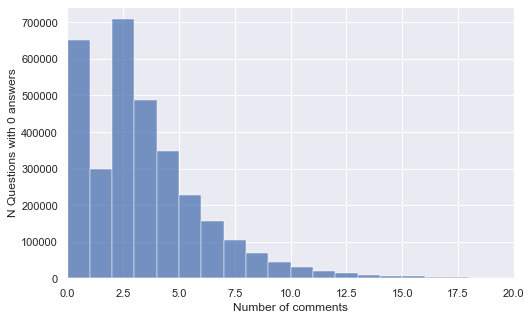

In [25]:
#histogram with x-axis limit set to 20
sns.set(rc={'figure.figsize':(8,5)})
hc= sns.histplot(data = df[df.answer_count==0], x="comment_count",binwidth=1)
hc.set( xlabel = "Number of comments", ylabel = "N Questions with 0 answers");
hc.set_xlim(0,20)

[Text(0.5, 0, 'Number of comments'),
 Text(0, 0.5, '% Questions with 0 answers')]

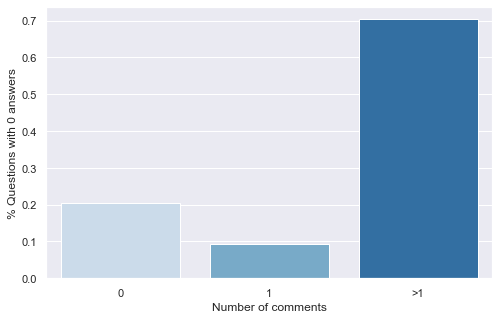

In [26]:
cat_comm = ['0', '1', '>1']
comm_distr = [(df.Id[(df.answer_count==0) & (df.comment_count==0) ].count()/df.Id[df.answer_count==0].count()),
             (df.Id[(df.answer_count==0) & (df.comment_count==1) ].count()/df.Id[df.answer_count==0].count()),
            (df.Id[(df.answer_count==0) & (df.comment_count>1) ].count()/df.Id[df.answer_count==0].count())]

sns.set(rc={'figure.figsize':(8,5)})
pc = sns.barplot(x = cat_comm, y = comm_distr,palette="Blues")
pc.set( xlabel = "Number of comments", ylabel = "% Questions with 0 answers")

Considering question with answers how many of them were accepted?

Around 85%

In [28]:
print(f'There are {df.Id[df.answer_count>0].count()} questions with at least 1 answer')
print(df.Id[df.answer_count>0].count()/df.Id.count())

There are 19108584 questions with at leat 1 answer
0.8566501171357469


In [27]:
print('The percentage of question with answers accepted is: {}' 
       .format((df.Id[(df.answer_count>0)  & (df.accepted_answer_id.notna())].count())/(df.Id[(df.answer_count>0)].count())
              ))

#df.Id[(df.answer_count==1)  & (df.accepted_answer_id.notna())].count()
#df[df.answer_count==1].head()

The percentage of question with answers accepted is: 0.5990079118369


In [29]:
print(df.Id[(df.answer_count==1)].count())
print(df.Id[(df.answer_count==1)  & (df.accepted_answer_id.notna())].count())

11332758
6318500


### **Create Tag trend**

Create a dictionary of tags where for each tag we count the posts for year-month

In [12]:
tag_dict_time = {}

tag_trend(df, tag_dict_time, tags='tags', year_month='post_creation_year_month')
df_tag_time = pd.DataFrame.from_dict(tag_dict_time)
df_tag_time= df_tag_time.T
df_tag_time.sort_index(axis=1, inplace=True)
df_tag_time.fillna(0, inplace= True)
df_tag_time.head()
df_tag_time['tag_index']=df_tag_time.index


In [13]:
df_tag_time.head()

2008-07  2008-08  2008-09  2008-10  2008-11  \
ruby-on-rails                 0.0     42.0    224.0    227.0    164.0   
ruby                          0.0     71.0    288.0    249.0    159.0   
undefined                     0.0      1.0      0.0      2.0      0.0   
polymorphic-associations      0.0      0.0      0.0      0.0      0.0   
railscasts                    0.0      0.0      0.0      0.0      0.0   

                          2008-12  2009-01  2009-02  2009-03  2009-04  ...  \
ruby-on-rails               173.0    265.0    262.0    364.0    380.0  ...   
ruby                        161.0    207.0    287.0    330.0    358.0  ...   
undefined                     4.0      2.0      4.0      0.0      3.0  ...   
polymorphic-associations      1.0      0.0      1.0      2.0      1.0  ...   
railscasts                    0.0      0.0      0.0      0.0      0.0  ...   

                          2021-07  2021-08  2021-09  2021-10  2021-11  \
ruby-on-rails               735.0    711.0    699.0    645.0    644.0   
ruby                        500.0    507.0    507.0    479.0    449.0   
undefined                    45.0     51.0     40.0     45.0     48.0   
polymorphic-associations      1.0      3.0      5.0      3.0      4.0   
railscasts                    0.0      0.0      0.0      0.0      0.0   

                          2021-12  2022-01  2022-02  2022-03  \
ruby-on-rails               597.0    672.0    701.0    150.0   
ruby                        437.0    478.0    491.0    102.0   
undefined                    38.0     45.0     52.0     13.0   
polymorphic-associations      4.0      7.0      0.0      1.0   
railscasts                    0.0      1.0      0.0      0.0   

                                         tag_index  
ruby-on-rails                        ruby-on-rails  
ruby                                          ruby  
undefined                                undefined  
polymorphic-associations  polymorphic-associations  
railscasts                              railscasts  

[5 rows x 166 columns]

In [15]:
df_tag_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62699 entries, ruby-on-rails to zspace
Columns: 166 entries, 2008-07 to tag_index
dtypes: float64(165), object(1)
memory usage: 82.4+ MB


In [14]:
#check python tag occurence
df_tag_time.loc['python',df_tag_time.columns[:-1]].sum()

1902116.0

This method is equivalent to df.sort_values(columns, ascending=False).head(n), but more performant.

In [196]:
#top5 = df_tag_time.nlargest(n=5, columns=['2021-09'])
#top5
#sns.barplot(data = top5[['2021-09']], x='2021-09', y = top5.index)

2008-07  2008-08  2008-09  2008-10  2008-11  2008-12  2009-01  \
python          0.0    122.0    538.0    508.0    452.0    439.0    631.0   
javascript      0.0    164.0    639.0    726.0    579.0    626.0    792.0   
reactjs         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
java            0.0    222.0   1136.0   1154.0    958.0    829.0   1149.0   
html            1.0    112.0    328.0    332.0    330.0    310.0    412.0   

            2009-02  2009-03  2009-04  ...  2021-07  2021-08  2021-09  \
python        629.0    764.0    767.0  ...  24067.0  23072.0  21903.0   
javascript    948.0   1007.0   1049.0  ...  17309.0  17012.0  16652.0   
reactjs         0.0      0.0      0.0  ...   8096.0   8109.0   8110.0   
java         1208.0   1438.0   1532.0  ...   8313.0   7937.0   7787.0   
html          476.0    522.0    520.0  ...   6815.0   6373.0   6100.0   

            2021-10  2021-11  2021-12  2022-01  2022-02  2022-03   tag_index  
python      22924.0  23447.0  22132.0  22799.0  25040.0   5079.0      python  
javascript  16177.0  15869.0  15354.0  16410.0  17283.0   3450.0  javascript  
reactjs      7699.0   7829.0   7673.0   8491.0   8639.0   1676.0     reactjs  
java         7776.0   8300.0   7570.0   7777.0   8368.0   1759.0        java  
html         6081.0   5900.0   5616.0   5974.0   6305.0   1316.0        html  

[5 rows x 166 columns]

In [17]:
#unique_tag=df_tag_time['tag_index'].unique()
#palette_tag = dict(zip(unique_tag, sns.color_palette(n_colors=len(unique_tag))))

In [63]:
'''
rel_index = []
for i in df_tag_time.columns[:-1]:
    top20 = df_tag_time.nlargest(n=20, columns=[i])
    rel_index.extend(list(top20.index))

rel_index_set = set(rel_index)
'''
df_to_r=df_tag_time.loc[list(rel_index_set), :]
df_to_r.drop(columns = ['tag_index', '2022-03', '2008-07'], inplace = True)


In [64]:
df_to_r.reset_index(inplace=True)
#df_to_r
df_to_r_long=pd.melt(df_to_r,id_vars=['index'])
df_to_r_long.rename(columns = {'index': 'tag', 'variable': 'year_month'}, inplace=True)
df_to_r_long.to_csv('df_to_r_long.csv')

In [331]:
palette_tag =[]
for i in df_tag_time.columns[[7,19,31,43,55,67,79,91,103,115,127,139,151,163]]: 
    top10 = df_tag_time.nlargest(n=10, columns=[i])
    palette_tag.extend(list(top10.index))

set_tag = set(palette_tag)

In [80]:
for i in df_tag_time.columns[:-1]: 
    top10 = df_tag_time.nlargest(n=5, columns=[i])
    print(i, top10.index)

2008-07 Index(['c#', 'datetime', 'html', 'css', '.net'], dtype='object')
2008-08 Index(['c#', '.net', 'asp.net', 'java', 'sql-server'], dtype='object')
2008-09 Index(['c#', '.net', 'java', 'asp.net', 'c++'], dtype='object')
2008-10 Index(['c#', '.net', 'java', 'asp.net', 'c++'], dtype='object')
2008-11 Index(['c#', '.net', 'java', 'asp.net', 'c++'], dtype='object')
2008-12 Index(['c#', '.net', 'asp.net', 'java', 'c++'], dtype='object')
2009-01 Index(['c#', '.net', 'java', 'asp.net', 'c++'], dtype='object')
2009-02 Index(['c#', '.net', 'java', 'asp.net', 'javascript'], dtype='object')
2009-03 Index(['c#', '.net', 'asp.net', 'java', 'c++'], dtype='object')
2009-04 Index(['c#', '.net', 'java', 'asp.net', 'javascript'], dtype='object')
2009-05 Index(['c#', '.net', 'java', 'asp.net', 'javascript'], dtype='object')
2009-06 Index(['c#', 'java', '.net', 'asp.net', 'php'], dtype='object')
2009-07 Index(['c#', 'java', '.net', 'php', 'asp.net'], dtype='object')
2009-08 Index(['c#', 'java', 'php',

In [332]:
#palette_set = dict(zip(set_tag, sns.color_palette("tab20",n_colors=len(set_tag))))

In [333]:
palette_set

{'iphone': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'python-3.x': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'php': (1.0, 0.4980392156862745, 0.054901960784313725),
 'c#': (1.0, 0.7333333333333333, 0.47058823529411764),
 'node.js': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'java': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'css': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'r': (1.0, 0.596078431372549, 0.5882352941176471),
 'sql-server': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'javascript': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'sql': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'ios': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'asp.net': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'python': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'reactjs': (0.498039215686

In [82]:
palette_set={'php': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'c++': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'c#': (1.0, 0.4980392156862745, 0.054901960784313725),
 'reactjs': (1.0, 0.7333333333333333, 0.47058823529411764),
 'jquery': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'r': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'javascript': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'java': (1.0, 0.596078431372549, 0.5882352941176471),
 'sql': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'ios': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'css': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'asp.net': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'python-3.x': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'sql-server': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'angular': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'node.js': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 'android': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'iphone': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 'python': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'html': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 '.net': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}


C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks(),size=25)
C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks(),size=25)
C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks(),size=25)
C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks(),size=25)
C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels(b.get_yticks(),size=25)
C:\Users\Eva\AppData\Local\Temp/ipykernel_31456/2631336781.py:18: UserWarni

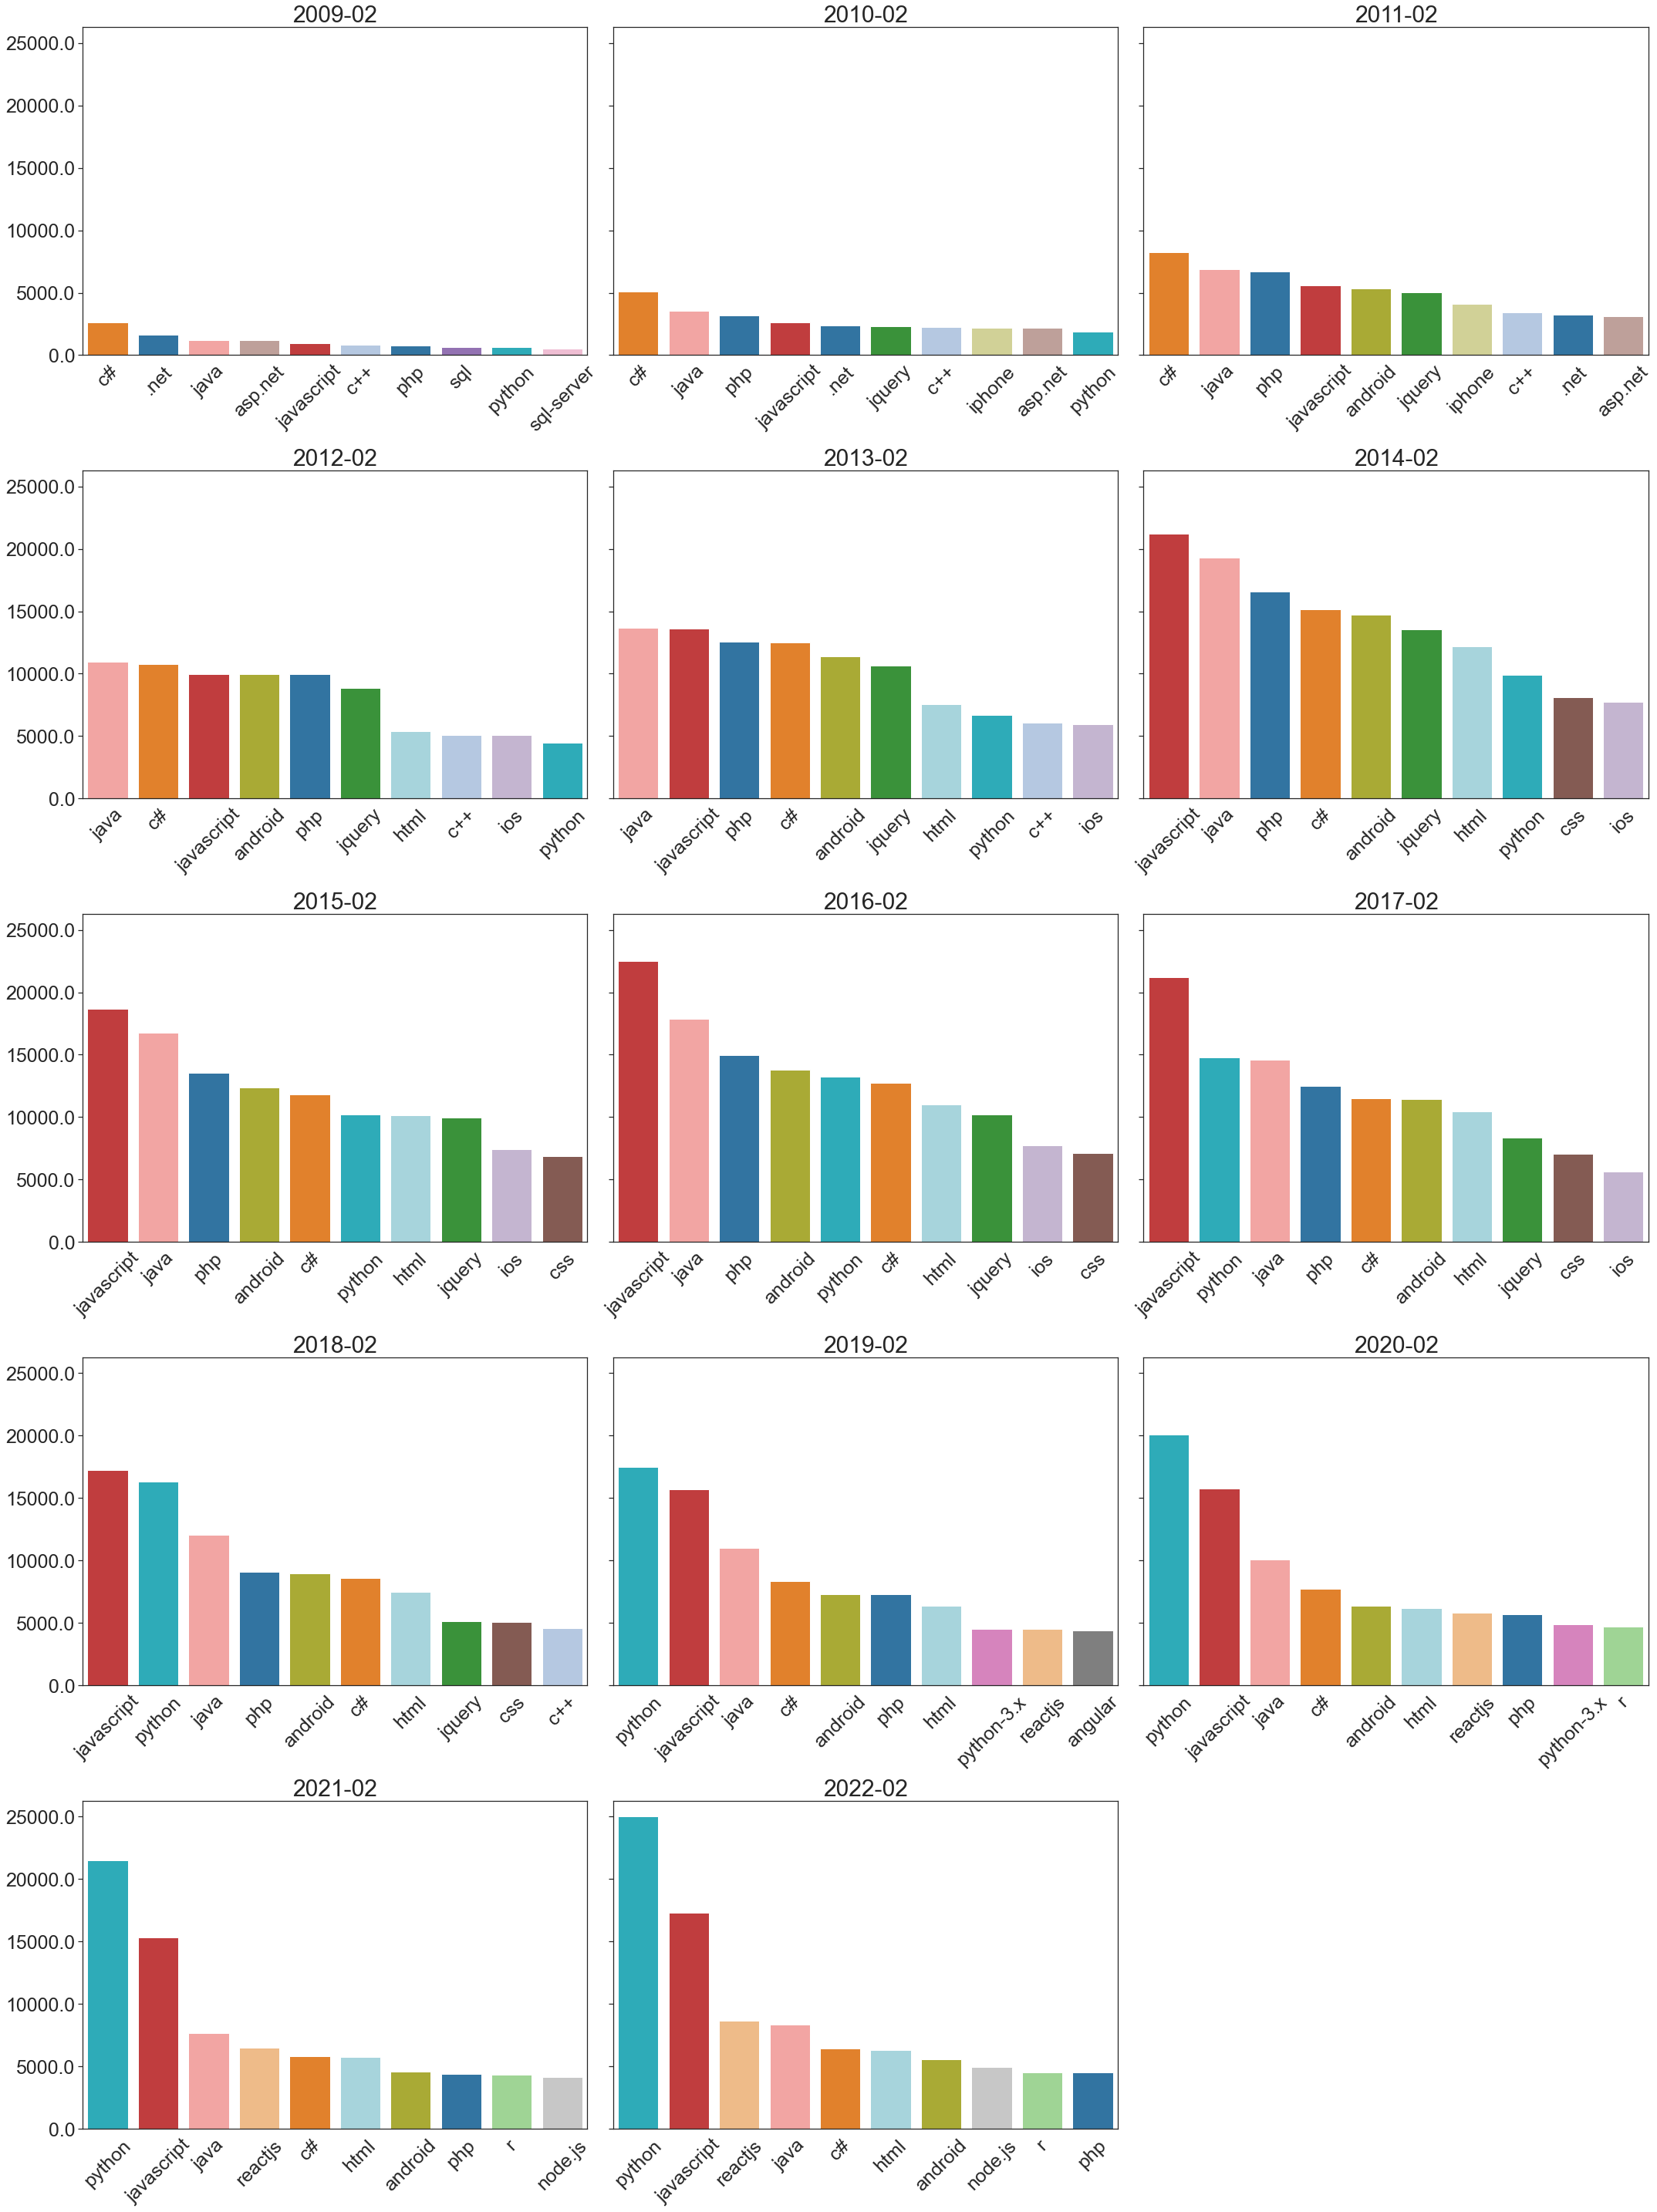

In [19]:
#sns.set(rc={'axes.facecolor':'lightgreen', 'figure.facecolor':'lightgreen'})
sns.set_style('white', rc={
    'xtick.bottom': False,
    'ytick.left': True,
})
fig, axarr =plt.subplots(5,3,sharey=True, figsize=(30,40))
fig.delaxes(axarr[4][2])

for i, col in enumerate(df_tag_time.columns[[7,19,31,43,55,67,79,91,103,115,127,139,151,163]]): 
    top10 = df_tag_time.nlargest(n=10, columns=[col])
    b= sns.barplot(data = top10, y=col, x = top10.index, ax=axarr.flatten()[i], hue = top10['tag_index'], palette=palette_set, dodge=False)
    b.legend_.remove()
    b.set_title('{}'.format(col),fontsize= 30)
    #b.set(xlabel="", ylabel="Post Count")
    #ax.set_xlabel('', fontsize=20)
    b.set_ylabel('')
    b.set_xticklabels(b.get_xticklabels(), rotation=45,fontsize=25)
    b.set_yticklabels(b.get_yticks(),size=25)
    plt.tight_layout();

In [393]:
fig.savefig('./figure/tag_barplot_time.png')

Let's build a dataframe with a selection of programming/markup languages 

In [72]:
def tag_trend_focus(df, tag_dict, tag_list, tags='tags', year_month='post_creation_year_month'):
    '''
    it returns a dictionary where each key is a tag and its value
    is a dictionary where the keys are year-month and the values are 
    the counts of posts that have that tag
    '''  
    for index in df.index:
        tag = ' ' + ' '.join(df[tags][index].split('|')) + ' '
        time = df[year_month][index]
        for item in tag_list:
            if re.search(item[0],tag):
                if item[1] not in tag_dict:
                    tag_dict[item[1]] = {time: 1}
                else: 
                    if time not in tag_dict[item[1]]:
                        tag_dict[item[1]][time] = 1
                    else:
                        temp = tag_dict[item[1]][time]
                        temp +=1
                        tag_dict[item[1]][time]= temp
    return tag_dict

In [73]:
tag_list_script= [[' python | python-\d.*','python'],['javascript','javascript'],[' c\+\+ | c\+\+\d+','c++'],
                  [' c# | c#-\d+','c#'], [' c ', 'c'],[' php ','php'], [' html | css ','html|css'], [' ruby ','ruby'], 
                  [' rust ','rust'], [' java | java-\d+','java'], [' go ','go'], [' typescript | typescript(\d.*)+','typescript'], 
                  [' r ','r'], [' matlab ','matlab'], [' sql | mysql | sql-server(-[0-9]{4})| postgresql','sql']]

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \+
<>:2: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \+
<>:2: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\Eva\AppData\Local\Temp/ipykernel_8936/3348978718.py:1: DeprecationWarning: invalid escape sequence \d
  tag_list_script= [[' python | python-\d.*','python'],['javascript','javascript'],[' c\+\+ | c\+\+\d+','c++'],
C:\Users\Eva\AppData\Local\Temp/ipykernel_8936/3348978718.py:1: DeprecationWarning: invalid escape sequence \+
  tag_list_script= [[' python | python-\d.*','python'],['javascript','javascript'],[' c\+\+ | c\+\+\d+','c++'],
C:\Users\Eva\AppData\Loc

In [74]:
tag_dict_focus = {}
tag_trend_focus(df, tag_dict_focus, tag_list_script, tags='tags', year_month='post_creation_year_month')

{'ruby': {'2015-03': 2461,
  '2017-09': 1222,
  '2011-09': 1549,
  '2014-07': 2562,
  '2016-09': 1924,
  '2016-12': 1627,
  '2017-06': 1417,
  '2017-03': 1790,
  '2018-02': 1031,
  '2018-12': 809,
  '2015-09': 2163,
  '2021-11': 449,
  '2013-01': 2307,
  '2021-10': 479,
  '2019-01': 917,
  '2021-01': 524,
  '2018-08': 880,
  '2019-05': 759,
  '2012-11': 2131,
  '2016-02': 2248,
  '2015-02': 2259,
  '2015-12': 2029,
  '2012-07': 2060,
  '2014-03': 2948,
  '2020-07': 698,
  '2018-05': 1033,
  '2015-06': 2577,
  '2017-11': 1177,
  '2017-05': 1519,
  '2017-04': 1488,
  '2015-05': 2503,
  '2018-09': 778,
  '2020-11': 504,
  '2012-06': 1889,
  '2020-04': 769,
  '2018-11': 833,
  '2014-06': 2337,
  '2013-02': 2219,
  '2017-07': 1521,
  '2021-09': 507,
  '2014-02': 2607,
  '2017-01': 1822,
  '2020-02': 653,
  '2016-11': 1757,
  '2013-07': 2443,
  '2013-04': 2460,
  '2021-04': 601,
  '2017-12': 1021,
  '2018-01': 1163,
  '2014-12': 2145,
  '2014-05': 2679,
  '2008-12': 161,
  '2018-04': 988,
  

In [75]:
df_selected = pd.DataFrame.from_dict(tag_dict_focus)
df_selected.fillna(0, inplace=True)
df_selected.sort_index(axis=0, inplace=True)

In [76]:
df_selected

ruby  javascript  html|css       c   python     c++     php    c#  \
2008-07    0.0         0.0         1     0.0      0.0     0.0     0.0     3   
2008-08   71.0       164.0       139    83.0    123.0   163.0   160.0   507   
2008-09  288.0       641.0       453   320.0    538.0   754.0   480.0  1649   
2008-10  249.0       726.0       463   303.0    508.0   811.0   615.0  2005   
2008-11  159.0       581.0       441   259.0    452.0   734.0   502.0  1768   
...        ...         ...       ...     ...      ...     ...     ...   ...   
2021-11  449.0     15901.0      7303  2342.0  25002.0  4212.0  4143.0  6423   
2021-12  437.0     15381.0      7008  2268.0  23518.0  3915.0  3769.0  5780   
2022-01  478.0     16445.0      7405  2083.0  24287.0  3952.0  4057.0  5983   
2022-02  491.0     17310.0      7814  2021.0  26675.0  4004.0  4535.0  6479   
2022-03  102.0      3454.0      1617   442.0   5425.0   891.0  1027.0  1351   

           java     go     sql       r  matlab  typescript   rust  
2008-07     0.0    0.0     0.0     0.0     0.0         0.0    0.0  
2008-08   222.0    0.0   261.0     0.0     2.0         0.0    0.0  
2008-09  1137.0    0.0   787.0     6.0    11.0         0.0    0.0  
2008-10  1155.0    0.0   911.0     0.0    21.0         0.0    0.0  
2008-11   958.0    0.0   806.0     1.0    11.0         0.0    0.0  
...         ...    ...     ...     ...     ...         ...    ...  
2021-11  8371.0  705.0  6653.0  4632.0   311.0      3166.0  510.0  
2021-12  7623.0  775.0  6329.0  3934.0   242.0      3056.0  664.0  
2022-01  7840.0  797.0  6221.0  4274.0   263.0      3366.0  629.0  
2022-02  8424.0  786.0  7018.0  4548.0   262.0      3544.0  562.0  
2022-03  1773.0  154.0  1480.0   884.0    61.0       673.0   94.0  

[165 rows x 15 columns]

In [77]:
#df_selected = df_selected.T
df_selected= df_selected[['python','c', 'c++','c#', 'javascript', 'java', 'php','sql', 'typescript', 'html|css', 'r', 'matlab', 
                         'rust', 'ruby', 'go']]
df_selected.tail(10)

python       c     c++    c#  javascript    java     php     sql  \
2021-06  26312.0  1993.0  4210.0  6430     17626.0  9227.0  4842.0  7444.0   
2021-07  25923.0  1708.0  3828.0  5954     17337.0  8368.0  4598.0  7084.0   
2021-08  24787.0  1618.0  3508.0  5768     17036.0  8006.0  4574.0  6861.0   
2021-09  23433.0  1798.0  3947.0  5772     16684.0  7880.0  4309.0  6616.0   
2021-10  24498.0  2202.0  4121.0  6043     16212.0  7831.0  4270.0  6537.0   
2021-11  25002.0  2342.0  4212.0  6423     15901.0  8371.0  4143.0  6653.0   
2021-12  23518.0  2268.0  3915.0  5780     15381.0  7623.0  3769.0  6329.0   
2022-01  24287.0  2083.0  3952.0  5983     16445.0  7840.0  4057.0  6221.0   
2022-02  26675.0  2021.0  4004.0  6479     17310.0  8424.0  4535.0  7018.0   
2022-03   5425.0   442.0   891.0  1351      3454.0  1773.0  1027.0  1480.0   

         typescript  html|css       r  matlab   rust   ruby     go  
2021-06      3188.0      8297  4937.0   272.0  528.0  468.0  640.0  
2021-07      3170.0      8422  4673.0   255.0  528.0  500.0  646.0  
2021-08      3270.0      7930  4571.0   197.0  482.0  507.0  781.0  
2021-09      3224.0      7533  4326.0   262.0  415.0  507.0  659.0  
2021-10      3320.0      7600  4744.0   239.0  476.0  479.0  761.0  
2021-11      3166.0      7303  4632.0   311.0  510.0  449.0  705.0  
2021-12      3056.0      7008  3934.0   242.0  664.0  437.0  775.0  
2022-01      3366.0      7405  4274.0   263.0  629.0  478.0  797.0  
2022-02      3544.0      7814  4548.0   262.0  562.0  491.0  786.0  
2022-03       673.0      1617   884.0    61.0   94.0  102.0  154.0

In [78]:
df_selected['python'].sum()

2064870.0

In [79]:
custom_colormap={'php': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'c++': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'c#': (1.0, 0.4980392156862745, 0.054901960784313725),
 'c': (0.8823529411764706, 0.7980392156862745, 0.54901960784313725),
 'r': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'javascript': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'java': (1.0, 0.596078431372549, 0.5882352941176471),
 'sql': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'typescript': (0.2490196078431373, 0.33725490196078434, 0.29411764705882354),
 'ruby': (0.6392156862745098, 0.15294117647058825, 0.1568627450980392),
 'matlab': (0.1088235294117647, 0.8588235294117647, 0.5529411764705883),
 'python': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 'html|css': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 'go': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'rust': (0.8803921568627451, 0.7803921568627451, 0.7803921568627451),}

C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:5

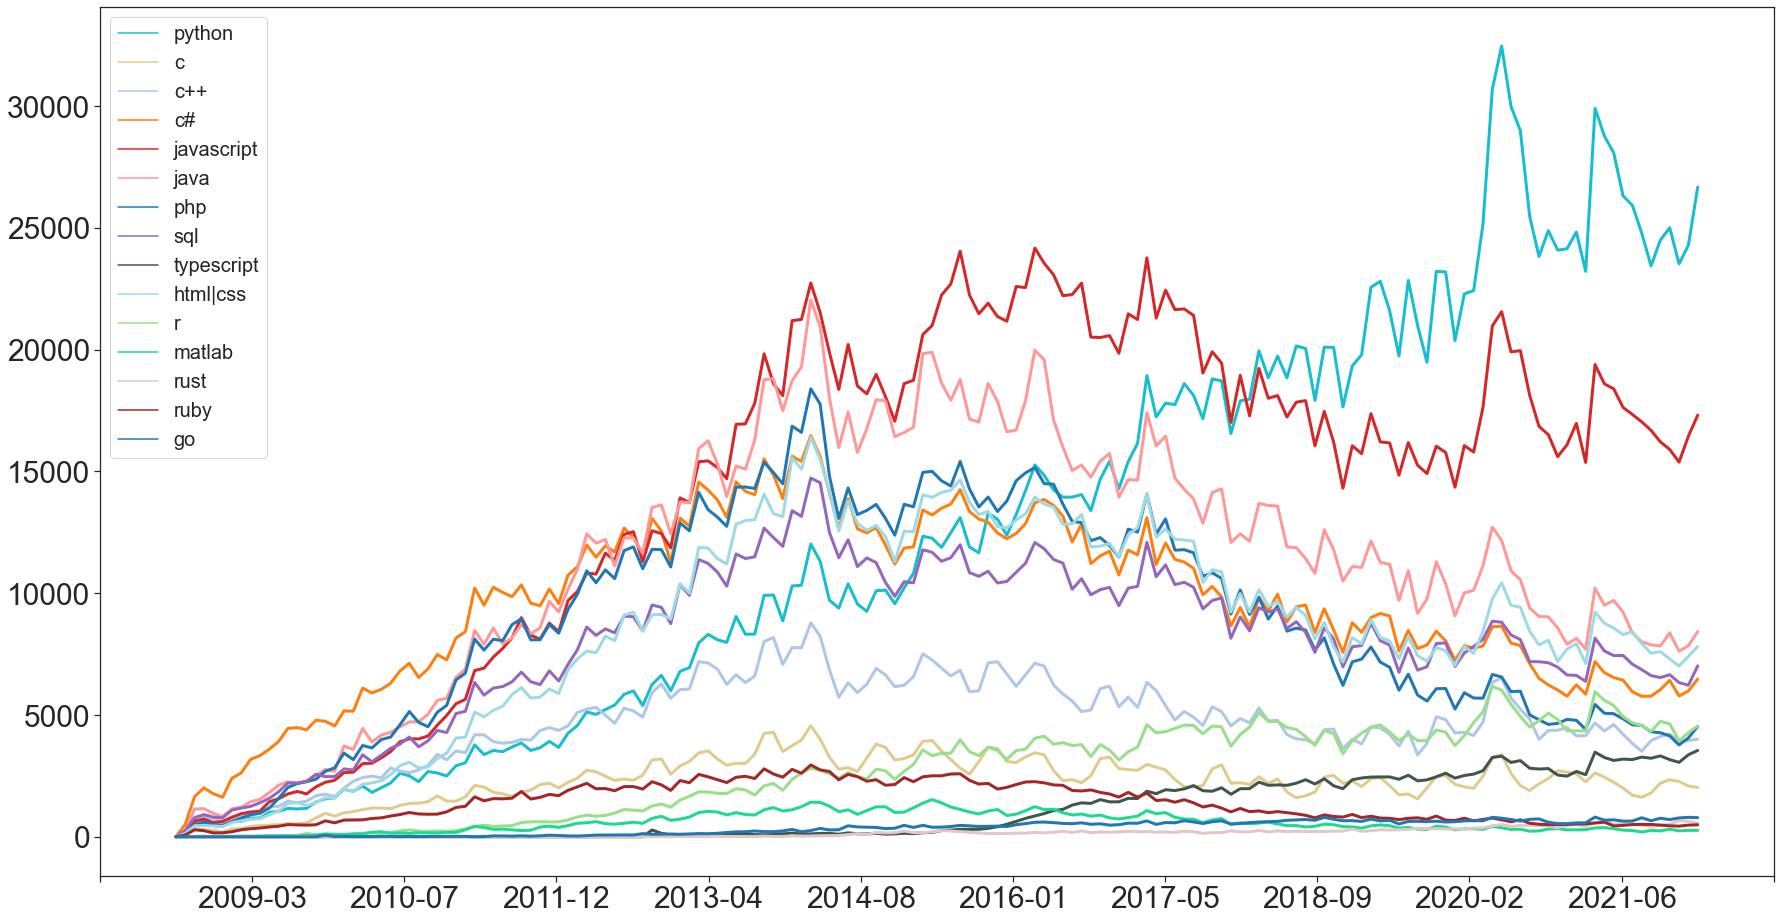

In [86]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(30,16)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

g = sns.lineplot(data=df_selected[df_selected.index !='2022-03'], palette=custom_colormap,dashes = False, linewidth=3)
g.xaxis.set_major_locator(ticker.LinearLocator(12))
#g.set_yticklabels(g.get_yticklabels(), fontsize=15)
g.tick_params(axis='y', labelsize =30)
g.tick_params(axis='x', labelsize =30)
#g.set_ylabels('Conteggio', fontsize=15)
#g.set_xticklabels(g.get_xticks(), size=15)
#g.set_yticklabels(g.get_yticks(),size=15)
#g.set_xticklabels(g.get_xticklabels(), rotation=40)
#g.set_xticklabels(['2009-09','2011-09','2013-09','2015-09','2017-09','2019-09','2021-09'])
#g.set_xticks(range(8))
#df_selected[df_selected.index !='2022-03'].plot(ylabel='number of posts',cmap=custom_colormap)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.legend(prop={'size': 20})
plt.show()

In [87]:
#fig.savefig('./figure/programming_time.png', bbox_inches = "tight")
fig.savefig('./pycon/programming_time.png', bbox_inches = "tight")

In [134]:
df_gtrends= pd.read_csv('gtrends.csv')

In [145]:
df_gtrends.set_index('Month', inplace=True)
df_gtrends.tail(2)

Python  JavaScript  C++  Java  SQL
Month                                      
2022-02      47          29   12    32   24
2022-03      48          30   13    33   25

In [147]:
g_trends_colormap={
 'C++': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'JavaScript': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Java': (1.0, 0.596078431372549, 0.5882352941176471),
 'SQL': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Python': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
}

C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:5

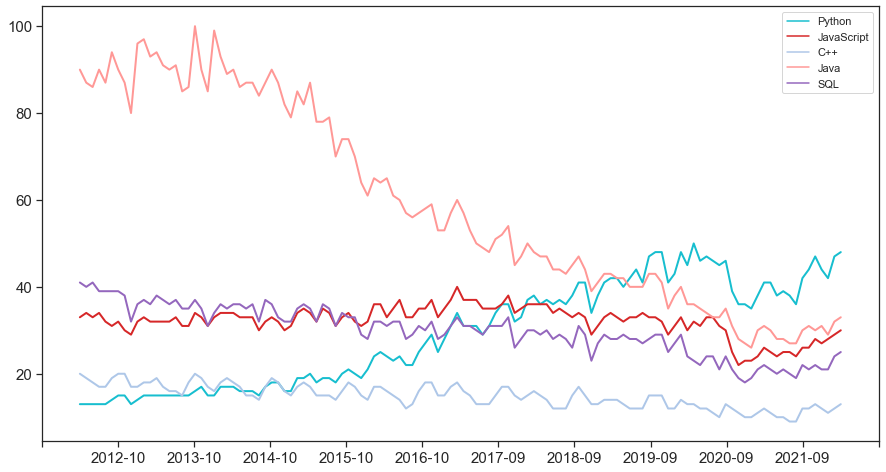

In [164]:
fig = plt.figure()

sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

g=sns.lineplot(data=df_gtrends, palette=g_trends_colormap,dashes = False, linewidth=2)
g.xaxis.set_major_locator(ticker.LinearLocator(12))
#g.set_yticklabels(g.get_yticklabels(), fontsize=15)
g.set_xlabel(None)
g.tick_params(axis='y', labelsize =15)
g.tick_params(axis='x', labelsize =15)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [152]:
#fig.savefig('./figure/gtrends.png', bbox_inches = "tight")

### **Check tags in post when there is 'python'**

In [88]:
start_time = time.time()
python_tag = ' python | python-\d.*'
tag_dict_python = {}
tag_trend_hierarchy(df, tag_dict_python, python_tag, tags='tags', year_month='post_creation_year_month')
end_time = time.time()

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\Eva\AppData\Local\Temp/ipykernel_8936/2882336254.py:2: DeprecationWarning: invalid escape sequence \d
  python_tag = ' python | python-\d.*'


In [133]:
len(tag_dict_python)

26283

In [91]:
df_tag_python = pd.DataFrame.from_dict(tag_dict_python)
df_tag_python= df_tag_python.T
df_tag_python.sort_index(axis=1, inplace=True)
df_tag_python.fillna(0, inplace= True)
df_tag_python.head()
df_tag_python['tag_index']=df_tag_python.index

In [33]:
df_tag_python.head()

2008-08  2008-09  2008-10  2008-11  2008-12  2009-01  2009-02  \
python            122.0    538.0    508.0    452.0    439.0    631.0    629.0   
python-asyncio      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
performance         2.0      6.0      3.0      4.0      3.0      5.0     12.0   
neo4j               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
benchmarking        0.0      1.0      0.0      0.0      0.0      0.0      1.0   

                2009-03  2009-04  2009-05  ...  2021-07  2021-08  2021-09  \
python            764.0    767.0    999.0  ...  24067.0  23072.0  21903.0   
python-asyncio      0.0      0.0      0.0  ...    140.0    101.0    103.0   
performance         7.0      7.0      7.0  ...     94.0     62.0     90.0   
neo4j               0.0      0.0      0.0  ...      9.0      6.0      8.0   
benchmarking        2.0      1.0      1.0  ...      2.0      3.0      1.0   

                2021-10  2021-11  2021-12  2022-01  2022-02  2022-03  \
python          22924.0  23447.0  22132.0  22799.0  25040.0   5079.0   
python-asyncio    102.0     89.0    120.0    114.0     96.0     28.0   
performance        77.0     88.0     74.0     75.0     99.0     21.0   
neo4j               7.0      4.0      7.0      6.0      9.0      1.0   
benchmarking        1.0      1.0      0.0      2.0      1.0      0.0   

                     tag_index  
python                  python  
python-asyncio  python-asyncio  
performance        performance  
neo4j                    neo4j  
benchmarking      benchmarking  

[5 rows x 165 columns]

In [504]:
#df_tag_python[df_tag_python.tag_index.apply(lambda x: bool(re.search('^python$|^python-\d.*', x)))]
#df_tag_python[(df_tag_python.index == 'machine-learning') |(df_tag_python.index == 'deep-learning') |(df_tag_python.index == 'flask')]

2008-08  2008-09  2008-10  2008-11  2008-12  2009-01  \
flask                 0.0      0.0      0.0      0.0      0.0      0.0   
machine-learning      0.0      0.0      0.0      0.0      0.0      0.0   
deep-learning         0.0      0.0      0.0      0.0      0.0      0.0   

                  2009-02  2009-03  2009-04  2009-05  ...  2021-07  2021-08  \
flask                 0.0      0.0      0.0      0.0  ...    621.0    431.0   
machine-learning      1.0      0.0      0.0      0.0  ...    308.0    376.0   
deep-learning         0.0      0.0      0.0      0.0  ...    193.0    243.0   

                  2021-09  2021-10  2021-11  2021-12  2022-01  2022-02  \
flask               420.0    392.0    482.0    403.0    380.0    554.0   
machine-learning    267.0    285.0    300.0    262.0    277.0    372.0   
deep-learning       186.0    191.0    213.0    216.0    208.0    238.0   

                  2022-03         tag_index  
flask                96.0             flask  
machine-learning     94.0  machine-learning  
deep-learning        58.0     deep-learning  

[3 rows x 165 columns]

I define a new dataset where I removed all the rows for python, python-3.x, python-2.7 and so on

In [166]:
df_python_hierarchy = df_tag_python[df_tag_python.tag_index.apply(lambda x: not bool(re.search('^python$|^python-\d.*', x)))]

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/3275092219.py:1: DeprecationWarning: invalid escape sequence \d
  df_python_hierarchy = df_tag_python[df_tag_python.tag_index.apply(lambda x: not bool(re.search('^python$|^python-\d.*', x)))]


In [167]:
df_python_hierarchy.shape

(26262, 165)

In [717]:
#python_hierarchy_list=[]
#for i in df_python_hierarchy.columns[:-1]: 
#    top10 = df_python_hierarchy.nlargest(n=15, columns=[i])
#    python_hierarchy_list.extend(list(top10.index))
#set(python_hierarchy_list)


Let's see the top 30 tags associated with Python

In [168]:
py_hi=df_python_hierarchy[df_python_hierarchy.columns[:-1]].sum(axis=1).sort_values(ascending= False).head(30)
#py_hi.to_csv('2019_2022_py_hi.csv')  

In [179]:
py_hi

pandas              216823.0
django              154533.0
numpy                93209.0
dataframe            73472.0
list                 65791.0
matplotlib           58100.0
tensorflow           46233.0
dictionary           44179.0
tkinter              43071.0
flask                39988.0
regex                35660.0
selenium             34680.0
csv                  31694.0
arrays               31584.0
json                 31409.0
string               30716.0
beautifulsoup        26858.0
html                 25964.0
keras                25841.0
web-scraping         25759.0
opencv               25068.0
machine-learning     24732.0
scikit-learn         21186.0
function             18214.0
pip                  18097.0
mysql                18080.0
loops                18068.0
scipy                17726.0
django-models        17659.0
python-requests      17646.0
dtype: float64

In [177]:
python_palette_set= { 'pandas':  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                      'django': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
                      'numpy': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
                      'dataframe': (1.0, 0.8, 0.0),
                      'list': (0.6, 0.8, 0.0),
                      'matplotlib':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),
                      'tensorflow': (1.0, 0.4980392156862745, 0.054901960784313725),
                      'dictionary': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                      'tkinter': (0.901961, 0.8, 1.0),
                      'flask': (0.896078431372549, 0.1745098039215686, 0.5411764705882353),
                      'regex': (0.0, 0.7019, 0.7019),
                      'selenium': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
                      'csv': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
                      'arrays':(1.0, 0.596078431372549, 0.5882352941176471) ,
                      'json': (0.6, 0.705, 0.5058823529411765),
                      'string': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
                      'beautifulsoup': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
                      'html': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
                      'keras': (0.7019, 0.1764, 0.0),
                      'web-scraping': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
                      'opencv': (1.0, 0.94, 0.0),
                      'machine-learning': (0.7725490196078432,0.6901960784313725,0.8352941176470589),
                      'scikit-learn': (1.0, 0.4980392156862745, 0.054901960784313725),
                      'function': (0.5, 0.85, 0.2),
                      'pip':(1.0, 0.596078431372549, 0.5882352941176471),
                      'mysql': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
                      'loops': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                      'scipy': (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
                      'django-models': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
                      'python-requests':(0.91823529411764706, 0.7803921568627451, 0.9098039215686274) }

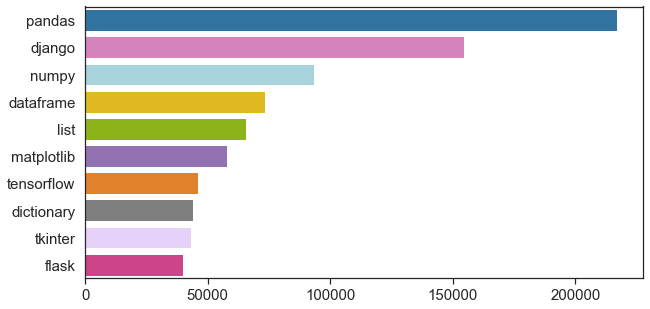

In [228]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': False,
})
f = sns.barplot( y=py_hi.index[:10], x=py_hi.values[0:10], palette = python_palette_set)
f.tick_params(labelsize=15)

In [230]:
fig.savefig('./figure/top10tag.png', bbox_inches = "tight")

In [720]:
#b=sns.lineplot(data=df_python_hierarchy[df_python_hierarchy.columns[:-2]].loc[['machine-learning', 'deep-learning'], :].T)
#b.xaxis.set_major_locator(ticker.LinearLocator(10))
#plt.legend(bbox_to_anchor=(1.0, 1.0))

C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:5

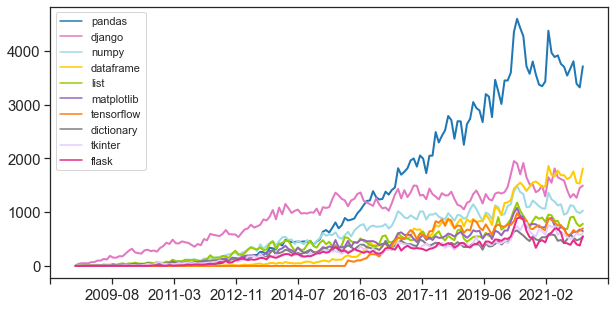

In [496]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
g = sns.lineplot(data=df_python_hierarchy[df_python_hierarchy.columns[:-2]].loc[py_hi.index[0:10], :].T, dashes = False, palette = python_palette_set,linewidth=2)
g.xaxis.set_major_locator(ticker.LinearLocator(10))
g.tick_params(labelsize=15)
#g.tick_params(axis='x', labelsize =15)
#g.tick_params(axis='y', labelsize =15)
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

#fig.savefig('./figure/top5tag_trend.png', bbox_inches = "tight")

In [741]:
'''
hierarchy_tag =[]
for i in df_python_hierarchy.columns[[6, 18, 30, 42, 54, 66, 78, 90, 102, 114, 126, 138,  150,  162]]: 
    top15p = df_python_hierarchy.nlargest(n=15, columns=[i])
    hierarchy_tag.extend(list(top15p.index))

set_hierarchy_tag = set(hierarchy_tag)

palette_hierarchy= dict(zip(set_hierarchy_tag, sns.color_palette("tab20",n_colors=len(set_hierarchy_tag))))
palette_hierarchy
sns.set_style('white', rc={
    'xtick.bottom': False,
    'ytick.left': True,
})
fig, axarr =plt.subplots(5,3,sharey=True, figsize=(60,60))
fig.delaxes(axarr[4][2])
palette_hierarchy = dict(zip(set_hierarchy_tag, sns.color_palette("tab20",n_colors=len(set_hierarchy_tag))))

for i, col in enumerate(df_python_hierarchy.columns[[6, 18, 30, 42, 54, 66, 78, 90, 102, 114, 126, 138,  150,  162]]):
    top15p = df_python_hierarchy.nlargest(n=15, columns=[col])
    b= sns.barplot(data = top15p, y=col, x = top15p.index, ax=axarr.flatten()[i], hue = top15p['tag_index'], palette=palette_hierarchy, dodge=False)
    b.legend_.remove()
    b.set_title('{}'.format(col),fontsize= 40)
    #b.set(xlabel="", ylabel="Post Count")
    #ax.set_xlabel('', fontsize=20)
    b.set_ylabel('')
    b.set_xticklabels(b.get_xticklabels(), rotation=45,fontsize=35)
    b.set_yticklabels(b.get_yticks(),size=35)
    plt.tight_layout()
'''
df.head()

Id                                             title  score  \
0  34379669                           How to make jar archive      0   
1  34054555                      C - Convert substring to int      2   
2  34025062         Application settings not saving correctly      4   
3  42772986                        Protein Mutual Information      2   
4  42794816  Jquery works only after launching developer tool      1   

   view_count                             tags post_creation_date  \
0         264                     java|csv|jar         2015-12-20   
1        2494                c|type-conversion         2015-12-02   
2         239                          c#|.net         2015-12-01   
3         873  python|bioinformatics|biopython         2017-03-13   
4         144            javascript|jquery|jsf         2017-03-14   

   answer_count  accepted_answer_id  comment_count  favorite_count  \
0             3                 NaN             11             NaN   
1             3          34054715.0             13             NaN   
2             0                 NaN             13             NaN   
3             2          42774436.0             11             1.0   
4             0                 NaN             11             NaN   

   owner_user_id user_creation_date  reputation  post_creation_year  \
0      5700065.0         2015-12-20         1.0                2015   
1      4712672.0         2015-03-25      1527.0                2015   
2       984577.0         2011-10-07       533.0                2015   
3      4893421.0         2015-05-12       785.0                2017   
4      4910936.0         2015-05-18       507.0                2017   

  post_creation_year_month  
0                  2015-12  
1                  2015-12  
2                  2015-12  
3                  2017-03  
4                  2017-03

Total posts, post with score equals to 0 and with a negative score

In [56]:
print(df_zot1.Id.count())
print(df_zot1.Id[df_zot1['score']==0].count())
print(df_zot1.Id[df_zot1['score']<0].count())

2895893
1632021
300060


In [53]:
tag_dict1 = {}
tag_extraction(df_zot1['tags'],tag_dict1)
len(tag_dict1)

48479

In [54]:
df_tag1 = pd.DataFrame.from_dict(tag_dict1.items())
df_tag1.sort_values(by = [1], ascending =False, inplace = True)
df_tag1.reset_index(inplace=True, drop=True)
df_tag1.head(10)

0       1
0      python  412176
1  javascript  300546
2        java  176623
3          c#  138803
4     reactjs  120487
5        html  117832
6     android  112217
7         php  103538
8  python-3.x   91484
9     node.js   88215

In [55]:
df_tag1.info()
#df_tag1.to_csv('2019_2022_1_answers.csv',  index=False)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48479 entries, 0 to 48478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       48479 non-null  object
 1   1       48479 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 757.6+ KB


In [49]:
df_tag0.info()
#df_tag0.to_csv('2019_2022_0_answers.csv',  index=False)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44980 entries, 0 to 44979
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       44980 non-null  object
 1   1       44980 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 702.9+ KB


# **Users**

In [94]:
user_sql = '''
SELECT
id,
EXTRACT (DATE FROM q.creation_date AT TIME ZONE "UTC") as user_creation_date,
EXTRACT (DATE FROM q.last_access_date AT TIME ZONE "UTC") as user_last_access_date,
reputation,
up_votes,
down_votes,
views
FROM `bigquery-public-data.stackoverflow.users`  as q
'''

In [95]:
query_job_users = client.query(user_sql, job_config=None)


In [96]:
start_time = time.time()
df_user = query_job_users.to_dataframe()
end_time = time.time()

In [97]:
end_time-start_time

117.85583519935608

In [98]:
df_user['user_creation_date_year']=pd.DatetimeIndex(df_user['user_creation_date']).year
df_user['user_last_access_date_year']=pd.DatetimeIndex(df_user['user_last_access_date']).year

In [107]:
df_user['user_creation_date_year_month']=pd.DatetimeIndex(df_user['user_creation_date']).to_period('M')
df_user['user_creation_date_year_month']= df_user['user_creation_date_year_month'].astype(str)

In [100]:
df_user.head(2)

id user_creation_date user_last_access_date  reputation  up_votes  \
0  8403096         2017-08-02            2021-12-21         447        28   
1  8407242         2017-08-02            2022-02-27         312         1   

   down_votes  views  user_creation_date_year  user_last_access_date_year  \
0           0     34                     2017                        2021   
1           1     63                     2017                        2022   

  user_creation_date_year_month  
0                       2017-08  
1                       2017-08

In [101]:
##tot utenti
df_user['id'].nunique()

17053422

In [102]:
##tot utenti with questions
df['owner_user_id'].nunique()

4471161

In [108]:
df_user_by_month = df_user[['id','user_creation_date_year_month']].groupby(by='user_creation_date_year_month').count()

In [109]:
df_user_by_month.tail(5)

id
user_creation_date_year_month        
2021-11                        254772
2021-12                        239340
2022-01                        276207
2022-02                        250547
2022-03                         48226

In [112]:
df_by_month = df[['Id','post_creation_year_month']].groupby(by='post_creation_year_month').count()

C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:436: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  scout, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:507: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  line, = ax.plot([], [], **kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\relational.py:337: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  artist = func([], [], label=label, **use_kws)
C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\seaborn\

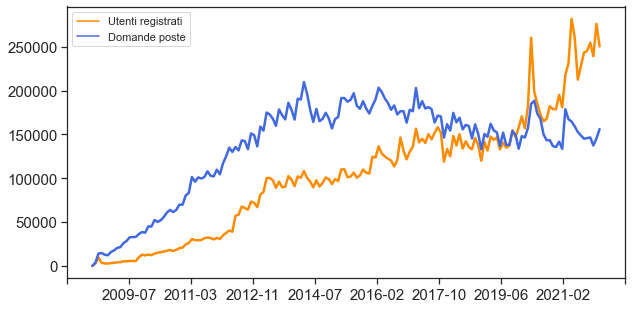

In [132]:
fig =plt.figure(figsize=(10,5))
#sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

b=sns.lineplot(data = df_user_by_month[df_user_by_month.index !='2022-03'], linewidth=2.5, palette=['darkorange'])
sns.lineplot(data = df_by_month[df_by_month.index !='2022-03'], linewidth=2.5, palette= ['royalblue'])
b.set(xlabel=None) 
b.xaxis.set_major_locator(ticker.LinearLocator(10))
b.tick_params(axis='y', labelsize =15)
b.tick_params(axis='x', labelsize =15)
#b.set_xticklabels(b.get_xticklabels(), fontsize=15)
#b.set(ylabel=None) 
#b.set_ylabel('Utenti registrati',fontsize= 15)
#plt.legend(labels=["Utenti registrati sul sito", 'Domande poste sul sito'])
legend = b.legend_
for t, l in zip(legend.texts,('Utenti registrati', 'Domande poste')):
    t.set_text(l)
#b.set_yticklabels(b.get_yticks() ,fontsize=15);
fig.savefig('./figure/user_creation.png', bbox_inches = "tight")

In [68]:
print(df_user[df_user['reputation']>=15].id.nunique())
print(df_user[df_user['reputation']>=75].id.nunique())
print(df_user[df_user['reputation']>=125].id.nunique())
print(df_user[df_user['reputation']>=1500].id.nunique())
print(df_user[df_user['reputation']>=2500].id.nunique())
print(df_user[df_user['reputation']>=10000].id.nunique())
print(df_user[df_user['reputation']>=25000].id.nunique())

2921783
1335302
963258
172068
108077
24900
8042


# **Python Related Tag Analysis**

In [743]:
#df.memory_usage()

In [12]:
sql_python = '''
SELECT 
id,
title,
body,
--post_type_id,
score,
view_count,
tags,
EXTRACT (DATE FROM creation_date AT TIME ZONE "UTC") as post_creation_date,
answer_count,
accepted_answer_id,
comment_count,
--favorite_count,
--owner_user_id
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE id IN 
(SELECT
id
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE REGEXP_CONTAINS(REGEXP_REPLACE(tags, r'\|', ' '), r'^python$|^python | python$| python |^python-\d.*|^python-\d.* | python-\d.* | python-\d.*')
)
'''

query_job_python = client.query(sql_python, job_config=None)


<>:1: DeprecationWarning: invalid escape sequence \|
<>:1: DeprecationWarning: invalid escape sequence \|
C:\Users\Eva\AppData\Local\Temp/ipykernel_10500/2471586930.py:1: DeprecationWarning: invalid escape sequence \|
  sql_python = '''


In [13]:
query_job_python.running()

False

In [14]:
start_time = time.time()
df_python = query_job_python.to_dataframe()
end_time = time.time()

In [15]:
end_time -start_time

514.4881327152252

Add year and month-year

In [16]:
df_python['post_creation_year']=pd.DatetimeIndex(df_python['post_creation_date']).year

In [17]:
df_python['post_creation_year_month']=pd.DatetimeIndex(df_python['post_creation_date']).to_period('M')
df_python['post_creation_year_month']= df_python['post_creation_year_month'].astype(str)

In [18]:
df_python['post_creation_date'] = df_python['post_creation_date'].astype(str)

In [20]:
df_python.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064870 entries, 0 to 2064869
Data columns (total 12 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int64  
 1   title                     object 
 2   body                      object 
 3   score                     int64  
 4   view_count                int64  
 5   tags                      object 
 6   post_creation_date        object 
 7   answer_count              int64  
 8   accepted_answer_id        float64
 9   comment_count             int64  
 10  post_creation_year        int64  
 11  post_creation_year_month  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 189.0+ MB


In [232]:
##read from pickle saved in the LDA section (only if you already ran the notebook and you saved the pkl)
#df_python = pd.read_pickle('./save_dataset/df_python_plus_token_pickle.pkl')

In [233]:
df_python.head()

id                                              title  \
0  2755403        Using recursion to sum two numbers (python)   
1  2473760  Python 'datetime.datetime' object is unsubscri...   
2  2803923                regular expression search in python   
3  3123340                               PyS60 vs Symbian C++   
4  2677713              Regex for finding valid sphinx fields   

                                                body  score  view_count  \
0  <p>I need to write a recursive function that c...      0        6690   
1  <p>First, I am NOT a python developer. I am tr...      1        6634   
2  <p>I am trying to parse some data and just sta...      1         432   
3  <p>I'm planning some Symbian related developme...      1        1015   
4  <p>I'm trying to validate that the fields give...      2         696   

                         tags post_creation_date  answer_count  \
0   python|function|recursion         2010-05-02             6   
1                      python         2010-03-18             6   
2         python|regex|string         2010-05-10             6   
3    c++|python|symbian|pys60         2010-06-26             6   
4  python|regex|django|sphinx         2010-04-20             6   

   accepted_answer_id  comment_count  post_creation_year  \
0           2755456.0              5                2010   
1           2473973.0              0                2010   
2           2803966.0              1                2010   
3           3123528.0              0                2010   
4           2678736.0              2                2010   

  post_creation_year_month                                        tokens  
0                  2010-05                      [recursion, sum, number]  
1                  2010-03  [datetime.datetime, object, unsubscriptable]  
2                  2010-05                 [regular, expression, search]  
3                  2010-06                         [pys60, symbian, c++]  
4                  2010-04           [regex, find, valid, sphinx, field]

Let's create a list where each element is a list of the tag of the post, eclusing python, python-3.x ecc

In [234]:
tags_r_python_list = []
for items in df_python['tags']:
    items_tag = items.split('|')
    tags = [tag for tag in items_tag if not re.search( r'^python$|^python-\d.*', tag)]
    if len(tags) ==0:
        continue
    tags_r_python_list.append(tags)

In [236]:
len(tags_r_python_list)

1873212

In [238]:
tags_r_python_list

[['function', 'recursion'],
 ['regex', 'string'],
 ['c++', 'symbian', 'pys60'],
 ['regex', 'django', 'sphinx'],
 ['algorithm', 'tuples'],
 ['c', 'ruby', 'programming-languages'],
 ['formatting', 'printing', 'dictionary'],
 ['import', 'path'],
 ['css', 'django', 'mobile', 'templates'],
 ['rest', 'web-services', 'apache2'],
 ['linux', 'bash', 'daemon', 'init.d'],
 ['geometry', 'intersection', 'points'],
 ['printing'],
 ['arrays', 'integer'],
 ['perl', 'bash', 'sed', 'awk'],
 ['list', 'dictionary', 'enumerate'],
 ['class', 'html'],
 ['lambda'],
 ['artificial-intelligence',
  'machine-learning',
  'classification',
  'neural-network'],
 ['decimal', 'rounding', 'ceil'],
 ['linux', 'key', 'keypress', 'simulate'],
 ['string-interpolation'],
 ['installation'],
 ['beautifulsoup'],
 ['sockets'],
 ['unique', 'uuid'],
 ['sql', 'database', 'in-memory-database'],
 ['r', 'matplotlib'],
 ['linux', 'process', 'uptime'],
 ['regex'],
 ['django', 'unit-testing', 'django-testing'],
 ['memory', 'zip', 'arch

In [24]:
#for tags in tags_r_python_list:
 #   print(list(itertools.combinations(tags, 2)))

In [237]:
tags_r_python_count = collections.Counter(itertools.chain.from_iterable(tags_r_python_list)).most_common(100)

## **NetworkX**

Let's create the Graph

In [240]:
G = nx.Graph()
G.add_nodes_from([(tag, {'count':count}) for tag,count in tags_r_python_count])

for tags in tags_r_python_list:
    for node0,node1 in itertools.combinations(tags, 2):
        if not G.has_node(node0) or not G.has_node(node1):
            continue
        if G.has_edge(node0, node1):
            G[node0][node1]["weight"] += 1
        else:
            G.add_edge(node0, node1, weight=1)

In [246]:
len(G.edges)

4476

Cleaning of the graph

C:\Users\Eva\.conda\envs\myclonebase\lib\site-packages\networkx\drawing\nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(


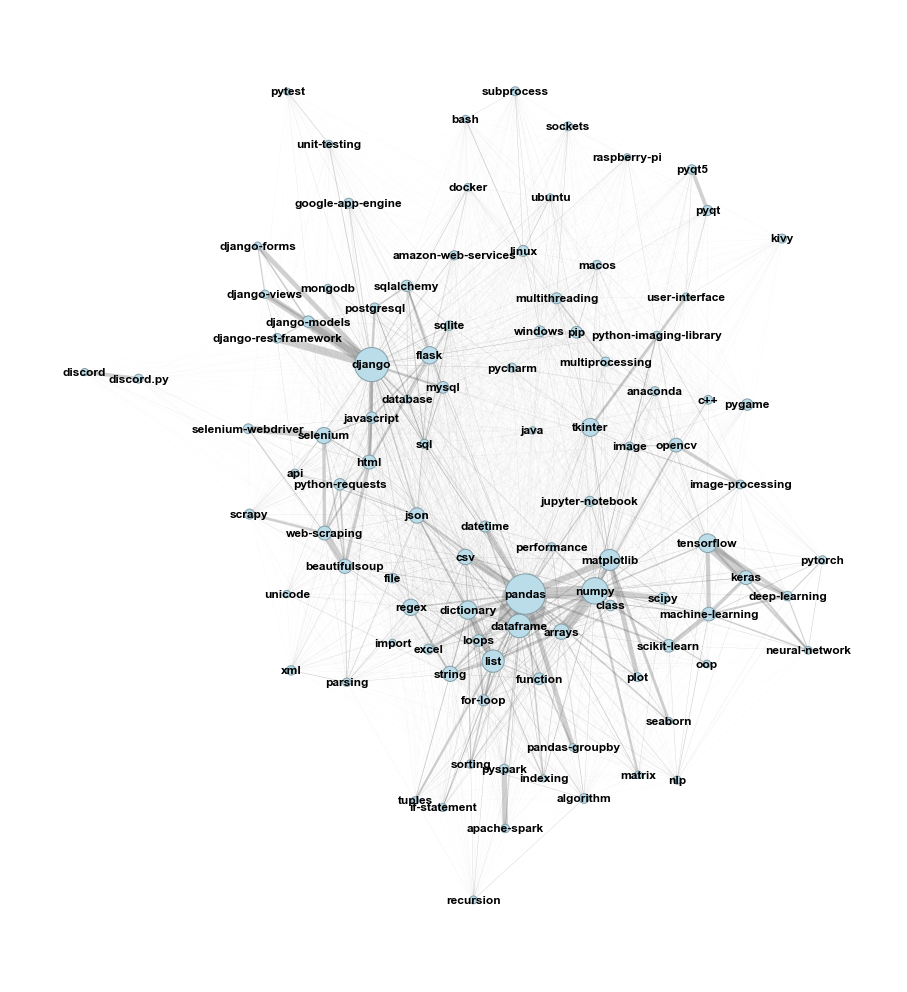

In [356]:
fig =plt.figure(figsize=(16,18))
pos = nx.spring_layout(G, seed =85, k=0.802, iterations = 101)
#pos = nx.spring_layout(G)

node_size = [ d['count']*0.0075 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color='#BBDDEA',alpha=1, node_size=node_size,edgecolors='#849FA9')
nx.draw_networkx_labels(G, pos, font_size = 12, font_weight="bold", font_color='black')

edge_width = [ d['weight']*0.0007 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='dimgrey', width=edge_width)
#nx.draw_networkx_edge_labels(G, pos, font_size = 14, font_weight="bold")

plt.axis('off')
plt.xlim()
plt.ylim()

#plt.savefig("g2.png ")
plt.show()

In [334]:
fig.savefig('./figure/graph.png', bbox_inches = "tight")

## **LDA**

Hyperparameters:

* Number of Topics (K)
* Dirichlet hyperparameter alpha: Document-Topic Density
* Dirichlet hyperparameter beta: Word-Topic Density

### **Onegram**

#### **Pre-processing with SPACY**

Add Python as stopword

In [37]:
spacy.load("en_core_web_md").Defaults.stop_words |= set(["python", "<", ">", "=", "`","+", "b","python3", "^", "vs"])

Add Pandas as exception in lemmas

In [888]:
#spacy.load("en_core_web_md").get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['pandas']=['pandas']
#spacy.load("en_core_web_md").get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['machine_learning']=['machine_learning']
#spacy.load("en_core_web_md").get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['deep_learning']=['deep_learning']

In [202]:
nlp_tag = spacy.load("en_core_web_md",disable=['parser', 'ner'])

In [531]:
nlp_tag.Defaults.stop_words

In [204]:
nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['pandas']=['pandas']
nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['machine_learning']=['machine_learning']
nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]['deep_learning']=['deep_learning']
nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"]['machine_learning']=['machine_learning']
nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"]['deep_learning']=['deep_learning']

In [196]:
for i in nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"]:
    print(i, nlp_tag.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"][i])

abetted ['abet']
abetting ['abet']
abhorred ['abhor']
abhorring ['abhor']
abode ['abide']
abought ['aby']
about-shipped ['about-ship']
about-shipping ['about-ship']
abutted ['abut']
abutting ['abut']
abye ['aby']
accompanied ['accompany']
acetified ['acetify']
acidified ['acidify']
acquitted ['acquit']
acquitting ['acquit']
ad-libbed ['ad-lib']
ad-libbing ['ad-lib']
addrest ['address']
admitted ['admit']
admitting ['admit']
aerified ['aerify']
air-dried ['air-dry']
airdropped ['airdrop']
airdropping ['airdrop']
alkalified ['alkalify']
allied ['ally']
allotted ['allot']
allotting ['allot']
allowed_for ['allow_for']
allowing_for ['allow_for']
allows_for ['allow_for']
am ['be']
ammonified ['ammonify']
amnestied ['amnesty']
amplified ['amplify']
anglified ['anglify']
annulled ['annul']
annulling ['annul']
appalled ['appal', 'appall']
appalling ['appal', 'appall']
applied ['apply']
arcked ['arc']
arcking ['arc']
are ['be']
argufied ['argufy']
arisen ['arise']
arose ['arise']
ate ['eat']
atr

In [205]:
prova = nlp_tag("pandas love machine_learning and also deep_learning but their learning is slow")
for i in prova:
    print(i.lemma_)

pandas
love
machine_learning
and
also
deep_learning
but
their
learning
be
slow


In [47]:
start_time = time.time()
tokens = []
for titles in tqdm(nlp_tag.pipe(df_python['title'], disable=['parser', 'ner'])):
    complete_filtered_tokens = [preprocess_token(token) for token in titles if is_token_allowed(token)]
    tokens.append(complete_filtered_tokens)
end_time= time.time()

2064870it [24:40, 1394.42it/s]


In [48]:
end_time - start_time

1480.810219526291

In [280]:
#df_python.drop(columns=['tokens'], axis=1, inplace=True)

In [49]:
df_python['tokens'] = tokens

In [50]:
### save to pickle if you want to avoid running the notebook for the topic analysis
#df_python.to_pickle('df_python_plus_token_pickle.pkl')

In [51]:
df_python.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2064870 entries, 0 to 2064869
Data columns (total 13 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int64  
 1   title                     object 
 2   body                      object 
 3   score                     int64  
 4   view_count                int64  
 5   tags                      object 
 6   post_creation_date        object 
 7   answer_count              int64  
 8   accepted_answer_id        float64
 9   comment_count             int64  
 10  post_creation_year        int64  
 11  post_creation_year_month  object 
 12  tokens                    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 204.8+ MB


In [45]:
#df_python[df_python.title.apply(lambda x: bool(re.search(r'\.', x)))]

In [340]:
#df_python['body'][2064540]

In [445]:
#df_python['title'][200]
df_python['tokens'][200]
#df_python.loc[200,['title','tokens']]

['remove', 'portion', 'string', 'come', 'semicolon', 'string']

In [52]:
df_python.shape

(2064870, 13)

#### **Create dictionary and corpus**

check of the token frequencies

In [368]:
dictionary_freq = Dictionary(df_python['tokens'])

In [369]:
len(dictionary_freq.token2id)

207888

In [711]:
#corpus_frequency = [dictionary_freq.doc2bow(doc) for doc in df_python['tokens']]

In [404]:
max(dictionary_freq.cfs.values())

167205

In [370]:
counts= collections.Counter(list(dictionary_freq.cfs.values()))
#sorted(counts.items())

In [530]:
#sorted(counts.items())

In [406]:
import numpy as np

C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/1836989254.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_xticklabels(f.get_xticks(), fontsize=15)
C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/1836989254.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_yticks(),size=15)


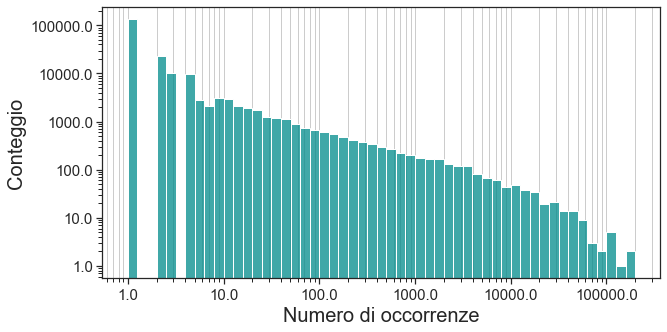

In [465]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
f=sns.histplot(data=list(dictionary_freq.cfs.values()), color = 'darkcyan',stat='count', binwidth=0.1, log_scale =10)
f.set_yscale("log")
f.set_xticklabels(f.get_xticks(), fontsize=15)
f.set_ylabel('Conteggio',fontsize= 20)
f.set_xlabel('Numero di occorrenze',fontsize= 20)
f.set_yticklabels(f.get_yticks(),size=15)
f.grid(which='both', axis='x')
f.tick_params(labelsize=15)
#plt.xticks(np.arange(1-0.05, 167205+0.05, 0.1))

In [466]:
fig.savefig('./figure/dict_freq.png', bbox_inches = "tight")

Get the top 30 word in dictionary by count

In [96]:
#dictionary_freq.filter_extremes(no_below=15, no_above=1, keep_n=100000)

In [413]:
dictionary_freq_sorted=dict(sorted(dictionary_freq.cfs.items(), key = itemgetter(1), reverse = True)[:10])

In [417]:
for key_u,value_u in dictionary_freq_sorted.items():
    key_name = [k for k, v in dictionary_freq.token2id.items() if v == key_u][0]
    print(key_name,key_u, value_u)
    #print(key_name, value_u)

list 70 167205
file 61 162635
value 230 143364
error 292 117160
django 34 111959
pandas 448 109642
function 136 101895
column 246 101064
string 79 87893
dataframe 888 83574


In [509]:
dictionary_freq.token2id['plot']

254

In [510]:
dictionary_freq.cfs[254]

31218

Let's create a dictionary from tokens with Gensim.Corpora.Dictionary

In [124]:
dictionary = Dictionary(df_python['tokens'])

In [127]:
len(dictionary.token2id)

207888

We filter our dict to remove key : value pairs with less than 15 occurrence

In [128]:
dictionary.filter_extremes(no_below=15, no_above=1, keep_n=100000)

In [129]:
print(len(dictionary.token2id))

15224


Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [130]:
start_time = time.time()
corpus = [dictionary.doc2bow(doc) for doc in df_python['tokens']]
end_time = time.time()

In [330]:
#dictionary.cfs[1353]

22010

#### **Coherence Score c_v**

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference

In [305]:
topics = []
score = []
start_time = time.time()
for i in tqdm(range(1,21,1)):   
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, 
                             num_topics=i, workers = 4, passes=1, random_state=100)   
    cm = CoherenceModel(model=lda_model, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')   
    topics.append(i)
    score.append(cm.get_coherence())
    
end_time = time.time()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:25:20<00:00, 256.04s/it]


In [518]:
end_time - start_time

3930.035826444626

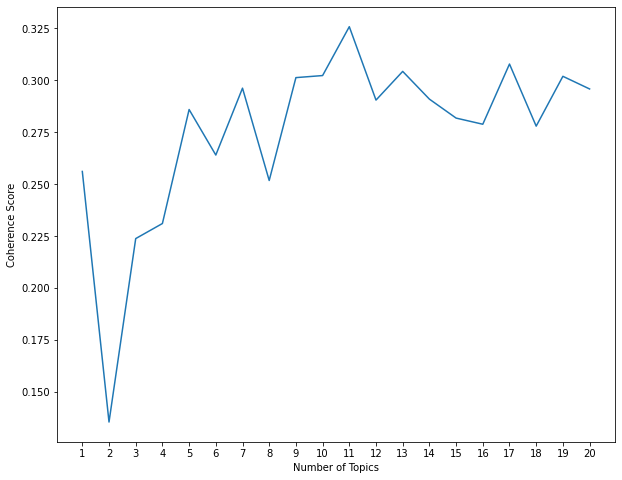

In [307]:
fig =plt.figure(figsize=(10,8))
plt.plot(topics, score)
plt.xticks(topics)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [131]:
##Try different number of topics

start_time = time.time()
lda_model_final_1 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=1, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_1.save('lda_model_final_1')

lda_model_final_2 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=2, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_2.save('lda_model_final_2')

lda_model_final_3 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=3, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_3.save('lda_model_final_3')

lda_model_final_4 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=4, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_4.save('lda_model_final_4')

lda_model_final_5 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=5, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_5.save('lda_model_final_5')


lda_model_final_6 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=6, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_6.save('lda_model_final_6')



lda_model_final_7 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=7, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_7.save('lda_model_final_7')

lda_model_final_8 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=8, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_8.save('lda_model_final_8')


lda_model_final_9 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=9, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_9.save('lda_model_final_9')


lda_model_final_10 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=10, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_10.save('lda_model_final_10')


lda_model_final_11 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=11, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_11.save('lda_model_final_11')


lda_model_final_12 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=12, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_12.save('lda_model_final_12')

lda_model_final_13 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=13, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_13.save('lda_model_final_13')

lda_model_final_14 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=14, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_14.save('lda_model_final_14')

lda_model_final_15 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=15, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_15.save('lda_model_final_15')

lda_model_final_16 = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=100, 
                         num_topics=16, 
                         workers = 4, passes=2, random_state=100)
#lda_model_final_16.save('lda_model_final_16')

end_time = time.time()

In [132]:
end_time-start_time

4756.437338590622

In [365]:
###load LDA model from saved files, create dictionary and corpus
'''
lda_model_final_1 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_1')
lda_model_final_2 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_2')
lda_model_final_3 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_3')
lda_model_final_4 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_4')
lda_model_final_5 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_5')
lda_model_final_6 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_6')
lda_model_final_7 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_7')
lda_model_final_8 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_8')
lda_model_final_9 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_9')
lda_model_final_10 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_10')
lda_model_final_11 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_11')
lda_model_final_12 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_12')
lda_model_final_13 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_13')
lda_model_final_14 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_14')
lda_model_final_15 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_15')
lda_model_final_16 =LdaMulticore.load('./save_lda_model_dictionary15mila/lda_model_final_16')
'''

'''
dictionary = Dictionary.load('./save_lda_model_dictionary15mila/lda_model_final_1.id2word')
corpus = [dictionary.doc2bow(doc) for doc in df_python['tokens']]
'''

In [431]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [420]:
cm1 = CoherenceModel(model=lda_model_final_1, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm2 = CoherenceModel(model=lda_model_final_2, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm3 = CoherenceModel(model=lda_model_final_3, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm4 = CoherenceModel(model=lda_model_final_4, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm5 = CoherenceModel(model=lda_model_final_5, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 


cm6 = CoherenceModel(model=lda_model_final_6, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm7 = CoherenceModel(model=lda_model_final_7, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm8 = CoherenceModel(model=lda_model_final_8, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm9 = CoherenceModel(model=lda_model_final_9, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm10 = CoherenceModel(model=lda_model_final_10, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm11 = CoherenceModel(model=lda_model_final_11, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm12 = CoherenceModel(model=lda_model_final_12, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm13 = CoherenceModel(model=lda_model_final_13, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm14 = CoherenceModel(model=lda_model_final_14, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 

cm15 = CoherenceModel(model=lda_model_final_15, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
cm16 = CoherenceModel(model=lda_model_final_16, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v') 
'''
print('cm6: {}'.format(cm6.get_coherence()), 
      'cm7: {}'.format(cm7.get_coherence()), 
      'cm8: {}'.format(cm8.get_coherence()), 
      'cm9: {}'.format(cm9.get_coherence()), 
      'cm10: {}'.format(cm10.get_coherence()), 
      'cm11: {}'.format(cm11.get_coherence()), 
      'cm12: {}'.format(cm12.get_coherence()), 
      'cm13: {}'.format(cm13.get_coherence()), 
      'cm14: {}'.format(cm14.get_coherence()))
'''



"\nprint('cm6: {}'.format(cm6.get_coherence()), \n      'cm7: {}'.format(cm7.get_coherence()), \n      'cm8: {}'.format(cm8.get_coherence()), \n      'cm9: {}'.format(cm9.get_coherence()), \n      'cm10: {}'.format(cm10.get_coherence()), \n      'cm11: {}'.format(cm11.get_coherence()), \n      'cm12: {}'.format(cm12.get_coherence()), \n      'cm13: {}'.format(cm13.get_coherence()), \n      'cm14: {}'.format(cm14.get_coherence()))\n"

In [421]:
n_topics = list(range(1,17))
cm_topics = [cm1.get_coherence(),cm2.get_coherence(),cm3.get_coherence(),cm4.get_coherence(),
             cm5.get_coherence(),cm6.get_coherence(),cm7.get_coherence(),cm8.get_coherence(),
             cm9.get_coherence(),cm10.get_coherence(),cm11.get_coherence(),cm12.get_coherence(),
             cm13.get_coherence(),cm14.get_coherence(),cm15.get_coherence(),cm16.get_coherence()]


Plot Coherence

C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/1558994952.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticks(), fontsize=15)
C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/1558994952.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(['{:,.2f}'.format(y) for y in l.get_yticks()] ,fontsize=15,);


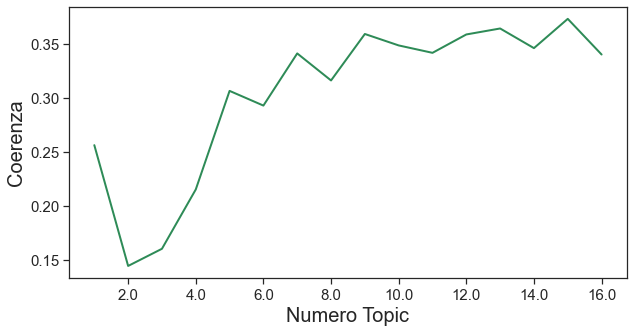

In [463]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
'''
plt.plot(n_topics, cm_topics)
plt.xticks(n_topics)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

'''
l=sns.lineplot(x=n_topics,y=cm_topics, color = 'seagreen', linewidth=2)
l.set_xticklabels(l.get_xticks(), fontsize=15)
l.set_ylabel('Coerenza',fontsize= 20)
l.set_xlabel('Numero Topic',fontsize= 20)
l.set_yticklabels(['{:,.2f}'.format(y) for y in l.get_yticks()] ,fontsize=15,);
l.tick_params(labelsize=15)

In [464]:
fig.savefig('./figure/coherence.png', bbox_inches = "tight")

In [467]:
t=0
model_list=[lda_model_final_6,lda_model_final_7,lda_model_final_8,lda_model_final_9,
            lda_model_final_10,lda_model_final_11,lda_model_final_12,lda_model_final_13,
            lda_model_final_14,  lda_model_final_15, lda_model_final_16]

for k in range(6,17):
    print('Model {}'.format(k))
    
    for i in range(0,k):
        model=model_list[t]
        print(model.show_topic(i, topn=10))
    print('\n')
    t+=1

Model 6
[('pandas', 0.06107299), ('column', 0.06019745), ('value', 0.053230714), ('dataframe', 0.04434138), ('array', 0.036010474), ('multiple', 0.031416614), ('row', 0.027452992), ('base', 0.021345913), ('numpy', 0.020260544), ('index', 0.012060243)]
[('way', 0.049908146), ('code', 0.015857812), ('problem', 0.012584223), ('tensorflow', 0.012336395), ('good', 0.011609647), ('simple', 0.009982846), ('time', 0.00993302), ('fast', 0.009497368), ('find', 0.008910211), ('model', 0.0083070295)]
[('django', 0.05144299), ('error', 0.027092975), ('class', 0.026041683), ('module', 0.022681553), ('run', 0.022196136), ('import', 0.019267844), ('script', 0.01563514), ('attribute', 0.014375802), ('work', 0.012459539), ('object', 0.01144551)]
[('list', 0.12422206), ('function', 0.042642005), ('dictionary', 0.03408188), ('value', 0.029320296), ('loop', 0.028588664), ('variable', 0.02410011), ('return', 0.019377377), ('key', 0.017298823), ('number', 0.016703878), ('element', 0.016527496)]
[('file', 0.0

In [128]:
#starter = pd.DataFrame(lda_model_final_16.show_topic(0, topn=10), columns = ['Topic{}'.format(0), 'Word_Prob_Topic{}'.format(0)])
#for i in range(1,10): 
#    new_one =pd.DataFrame(lda_model_final_16.show_topic(i, topn=10), columns = ['Topic{}'.format(i), 'Word_Prob_Topic{}'.format(i)])
#    starter = pd.concat([starter,new_one], axis=1 )

In [560]:
get_document_topics = [lda_model_final_13.get_document_topics(item) for item in corpus[:10]]
print(get_document_topics)

[[(0, 0.34194466), (1, 0.019231498), (2, 0.01923134), (3, 0.44650987), (4, 0.019231554), (5, 0.01923134), (6, 0.01923134), (7, 0.01923134), (8, 0.019231342), (9, 0.019231709), (10, 0.01923134), (11, 0.01923134), (12, 0.01923134)], [(0, 0.019287463), (1, 0.019287463), (2, 0.019288624), (3, 0.5204896), (4, 0.019287463), (5, 0.019287463), (6, 0.019287463), (7, 0.019287463), (8, 0.019287463), (9, 0.26734698), (10, 0.019287463), (11, 0.019287664), (12, 0.019287463)], [(0, 0.019231109), (1, 0.019231139), (2, 0.019231109), (3, 0.019231113), (4, 0.26922515), (5, 0.019231109), (6, 0.019231109), (7, 0.51923263), (8, 0.019231109), (9, 0.019231109), (10, 0.019231109), (11, 0.019231109), (12, 0.019231109)], [(0, 0.02573831), (1, 0.35243577), (2, 0.36444277), (3, 0.02573831), (4, 0.02573831), (5, 0.02573831), (6, 0.02573831), (7, 0.02573831), (8, 0.02573831), (9, 0.02573831), (10, 0.02573831), (11, 0.02573831), (12, 0.02573831)], [(0, 0.012822202), (1, 0.50942826), (2, 0.01282221), (3, 0.012822254),

In [588]:
'''
def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        #for j, (topic_num, prop_topic) in enumerate(row):
            #if j == 0:  # => dominant topic
                #wp = ldamodel.show_topic(topic_num,  topn=5)
                #topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        sent_topics_df = sent_topics_df.append(pd.Series([int(row[0][0]), round(row[0][1],4)]), ignore_index=True)
            #else:
                #break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final_13, corpus=corpus)
'''

In [622]:
'''
sent_topics_df = pd.DataFrame()
for i, row in enumerate(lda_model_final_13[corpus[:5]]):
    print(row)
    row = sorted(row, key=lambda x:(x[1]), reverse=True)
    print(row)
    print(row[0][0], row[0][1])
    #for j, (topic_num, prop_topic) in enumerate(row):
        #print(j,(topic_num, prop_topic))
    sent_topics_df = sent_topics_df.append(pd.Series([int(row[0][0]), round(row[0][1],4)]), ignore_index=True)

'''
#

'\nsent_topics_df = pd.DataFrame()\nfor i, row in enumerate(lda_model_final_13[corpus[:5]]):\n    print(row)\n    row = sorted(row, key=lambda x:(x[1]), reverse=True)\n    print(row)\n    print(row[0][0], row[0][1])\n    #for j, (topic_num, prop_topic) in enumerate(row):\n        #print(j,(topic_num, prop_topic))\n    sent_topics_df = sent_topics_df.append(pd.Series([int(row[0][0]), round(row[0][1],4)]), ignore_index=True)\n\n'

In [586]:
sent_topics_df

0       1
0  3.0  0.4468
1  3.0  0.5205
2  7.0  0.5192
3  2.0  0.3644
4  1.0  0.5094

In [600]:
sent_topics_list = []
for item in tqdm(lda_model_final_13.get_document_topics(bow=corpus)):
    #print(item)
    row = sorted(item, key=lambda x: (x[1]), reverse=True)
    #print(row)
    #print([int(row[0][0]), round(row[0][1],4)])
    sent_topics_list.append([int(row[0][0]), round(row[0][1],4)])

100%|██████████████████████████████████████████████████████████████████████| 2064870/2064870 [06:56<00:00, 4959.07it/s]


In [603]:
df_topic_dominant = pd.DataFrame(sent_topics_list, columns = ['Dominant_Topic', 'Perc_Contribution'])
#list(lda_model_final_13.get_document_topics(bow=corpus[:10]))

In [606]:
print(df_python.shape, df_topic_dominant.shape)

(2064870, 13) (2064870, 2)


In [607]:
df_python_dominant_topic= pd.concat([df_python,df_topic_dominant], axis=1)

In [623]:
df_python_dominant_topic.head(5)

id                                              title  \
0  2755403        Using recursion to sum two numbers (python)   
1  2473760  Python 'datetime.datetime' object is unsubscri...   
2  2803923                regular expression search in python   
3  3123340                               PyS60 vs Symbian C++   
4  2677713              Regex for finding valid sphinx fields   

                                                body  score  view_count  \
0  <p>I need to write a recursive function that c...      0        6690   
1  <p>First, I am NOT a python developer. I am tr...      1        6634   
2  <p>I am trying to parse some data and just sta...      1         432   
3  <p>I'm planning some Symbian related developme...      1        1015   
4  <p>I'm trying to validate that the fields give...      2         696   

                         tags post_creation_date  answer_count  \
0   python|function|recursion         2010-05-02             6   
1                      python         2010-03-18             6   
2         python|regex|string         2010-05-10             6   
3    c++|python|symbian|pys60         2010-06-26             6   
4  python|regex|django|sphinx         2010-04-20             6   

   accepted_answer_id  comment_count  post_creation_year  \
0           2755456.0              5                2010   
1           2473973.0              0                2010   
2           2803966.0              1                2010   
3           3123528.0              0                2010   
4           2678736.0              2                2010   

  post_creation_year_month                                        tokens  \
0                  2010-05                      [recursion, sum, number]   
1                  2010-03  [datetime.datetime, object, unsubscriptable]   
2                  2010-05                 [regular, expression, search]   
3                  2010-06                         [pys60, symbian, c++]   
4                  2010-04           [regex, find, valid, sphinx, field]   

   Dominant_Topic  Perc_Contribution  
0               3             0.4466  
1               3             0.5205  
2               7             0.5192  
3               2             0.3644  
4               1             0.5094

In [627]:
df_python_dominant_topic.shape

(2064870, 15)

In [625]:
df_python_dominant_topic['Dominant_Topic'].value_counts().sum()

2064870

In [629]:
topic_contribution = round(df_python_dominant_topic['Dominant_Topic'].value_counts()/df_python_dominant_topic['Dominant_Topic'].value_counts().sum(), 4)
print(topic_contribution)

3     0.1138
9     0.1019
2     0.1014
11    0.0877
10    0.0853
7     0.0818
4     0.0801
6     0.0729
12    0.0683
5     0.0593
0     0.0572
8     0.0488
1     0.0416
Name: Dominant_Topic, dtype: float64


#### **Write Models to Excel**

Write the model in an Excel file

In [130]:
t=0
model_list=[lda_model_final_6,lda_model_final_7,lda_model_final_8,lda_model_final_9,
            lda_model_final_10,lda_model_final_11,lda_model_final_12,lda_model_final_13,
            lda_model_final_14,  lda_model_final_15, lda_model_final_16]

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Model_6-16.xlsx', engine='xlsxwriter')

for k in range(6,17):
    print('Model {}'.format(k))
    
    model=model_list[t]
    starter = pd.DataFrame(model.show_topic(0, topn=30), columns = ['Topic{}'.format(0), 'Word_Prob_Topic{}'.format(0)])
    for i in range(1,k): 
        new_one =pd.DataFrame(model.show_topic(i, topn=30), columns = ['Topic{}'.format(i), 'Word_Prob_Topic{}'.format(i)])
        starter = pd.concat([starter,new_one], axis=1)
    starter.to_excel(writer, sheet_name = 'Model_{}'.format(k))
    t+=1
                     
writer.save()

Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16


#### **Create WordCloud**

In [542]:
#sum(dict(lda_model_final_13.show_topic(0,topn=len(dictionary))).values())

1.0000000473332875

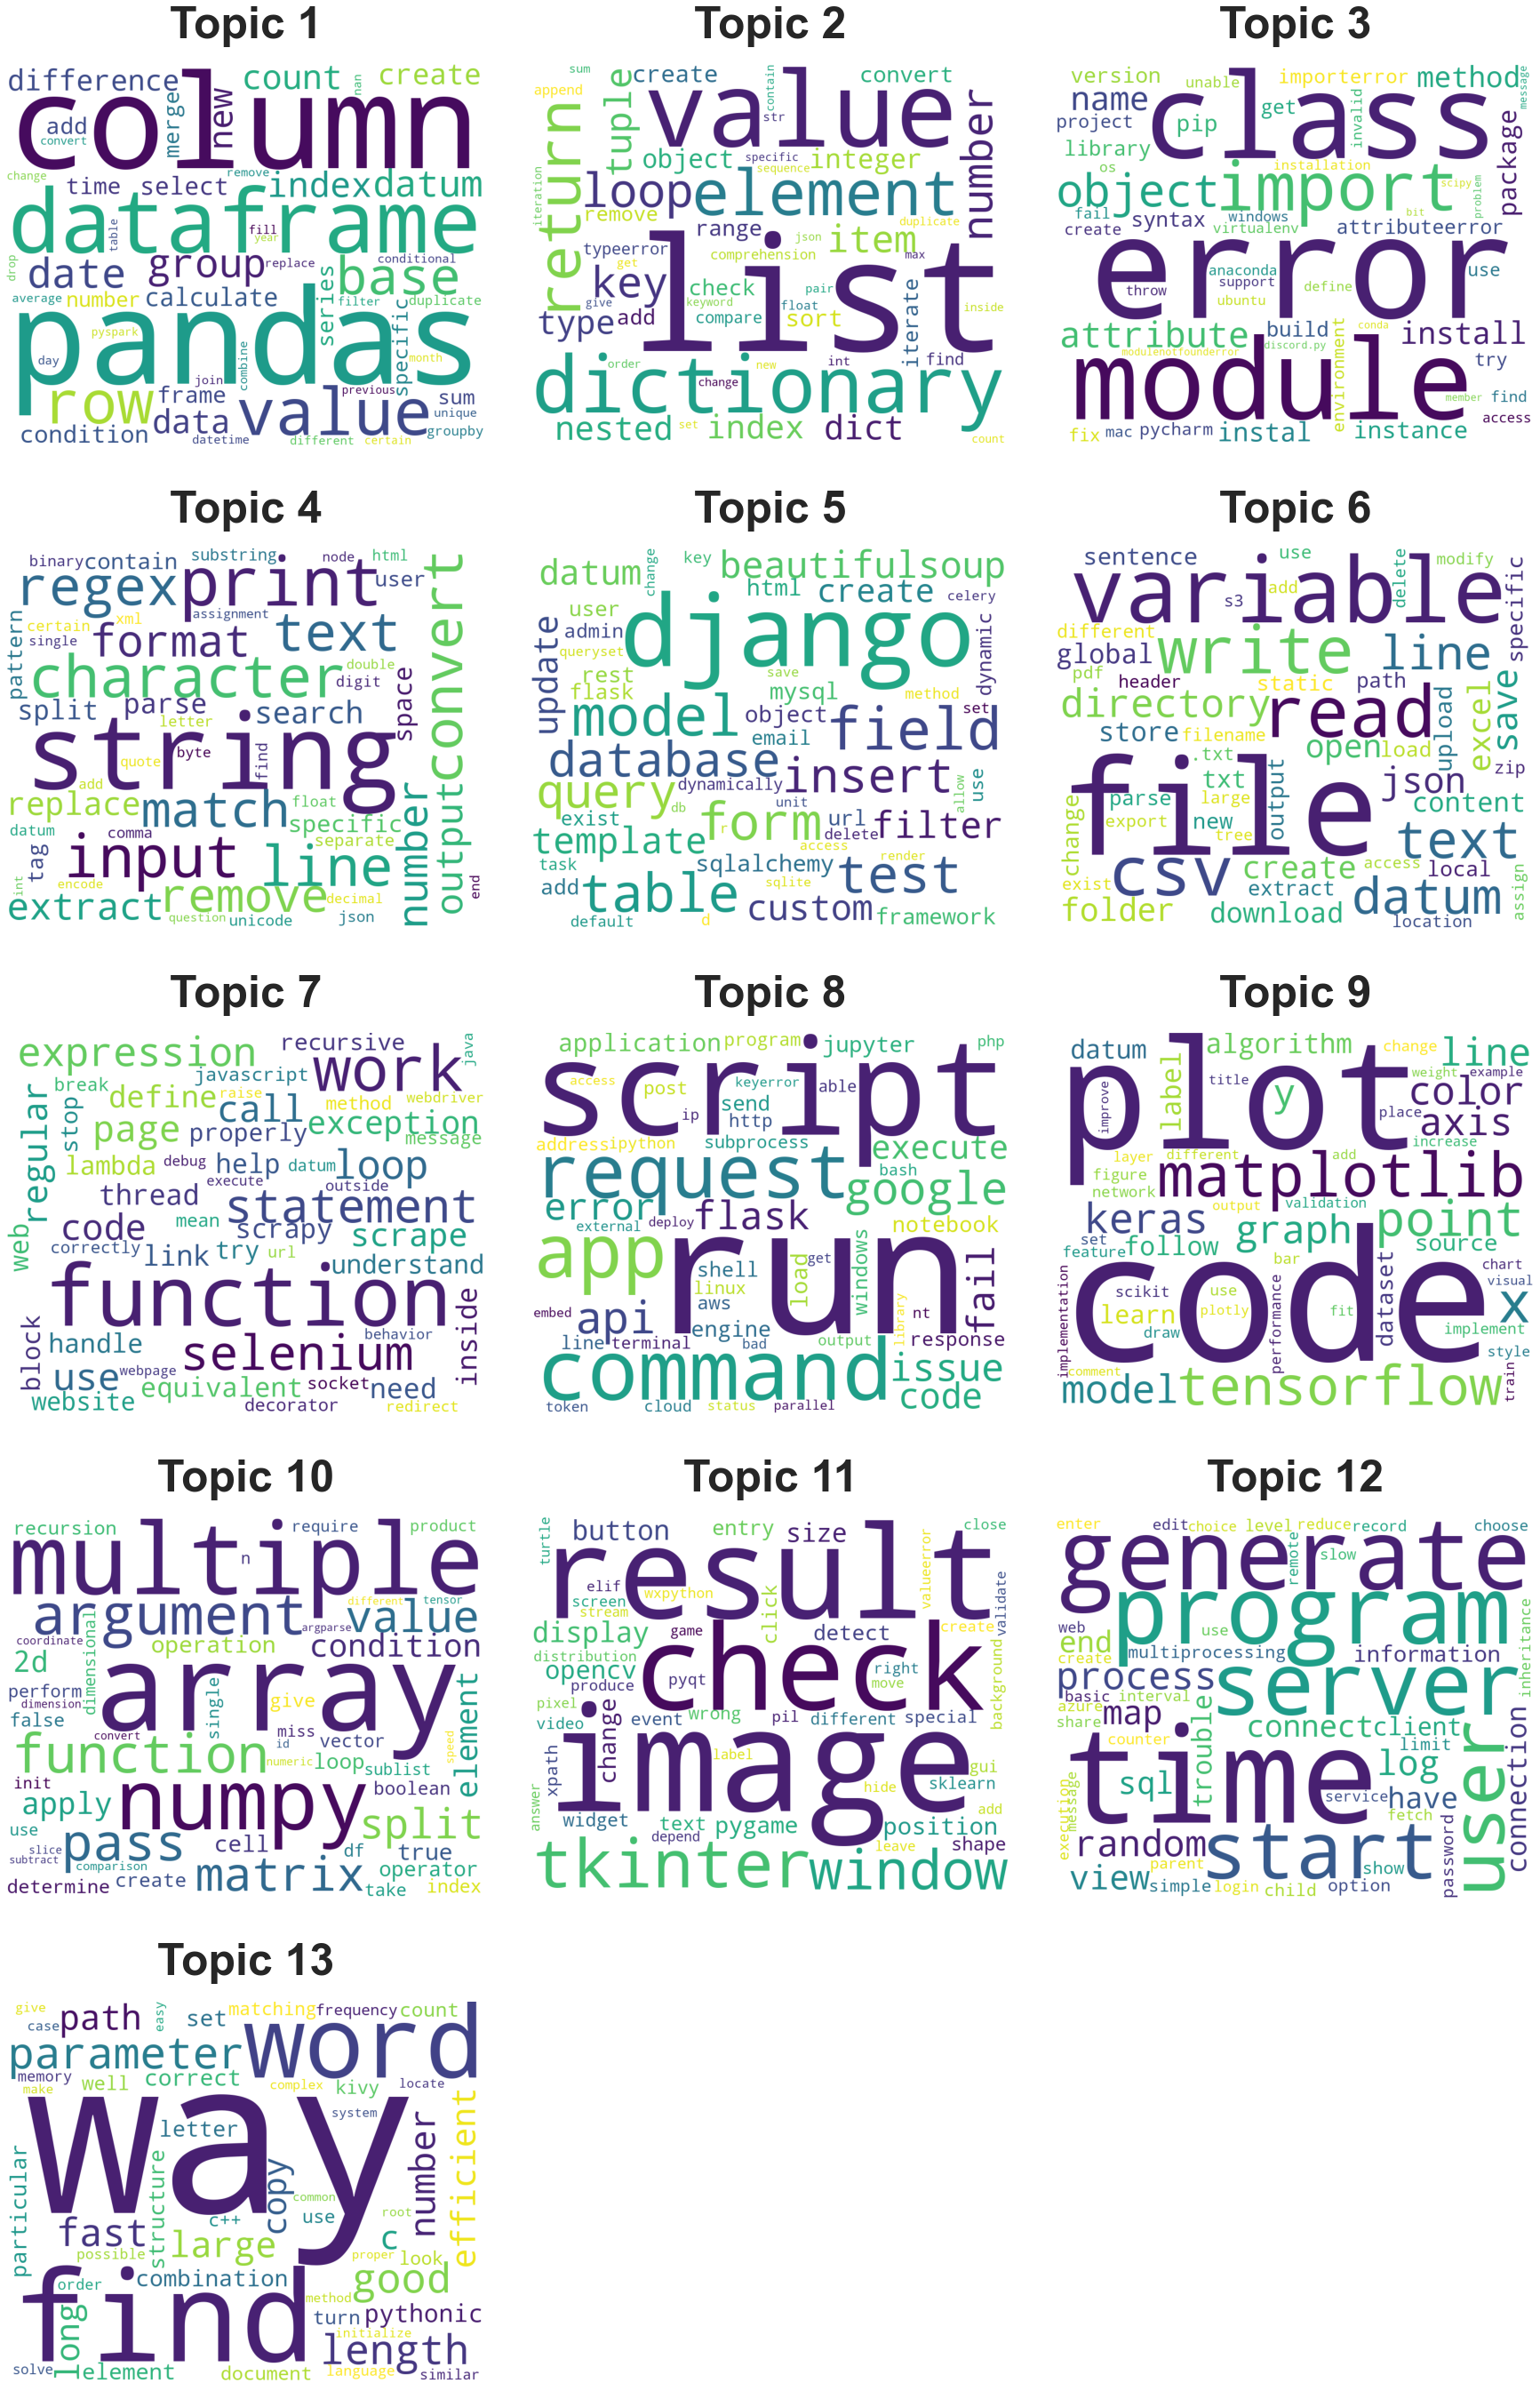

In [527]:
# print wordcloud
fig, axarr =plt.subplots(5,3,sharey=True, figsize=(25,38))
fig.delaxes(axarr[4][1])
fig.delaxes(axarr[4][2])
fig.tight_layout(h_pad=3,pad=2, w_pad=3)

lista_topics = [lda_model_final_13.show_topic(9, topn=50),lda_model_final_13.show_topic(3, topn=50),lda_model_final_13.show_topic(2, topn=50),lda_model_final_13.show_topic(4, topn=50),
               lda_model_final_13.show_topic(11, topn=50),lda_model_final_13.show_topic(10, topn=50),lda_model_final_13.show_topic(7, topn=50),lda_model_final_13.show_topic(6, topn=50),
               lda_model_final_13.show_topic(12, topn=50),lda_model_final_13.show_topic(0, topn=50), lda_model_final_13.show_topic(5, topn=50),lda_model_final_13.show_topic(8, topn=50),
               lda_model_final_13.show_topic(1, topn=50)]

for i in range(0,13):
    wc = WordCloud(random_state = 42, 
              background_color = "white", 
              contour_width=4,
              contour_color='black',
               width=1000, 
               height=800).generate_from_frequencies(dict(lista_topics[i]))
    ax=axarr.flatten()[i]
    ax.set_title('Topic {}'.format(i+1),fontdict={'fontsize': 50, 'fontweight': 'bold'}, pad=30)
    ax.imshow(wc)
    ax.axis("off")
    #plt.tight_layout();

In [528]:
fig.savefig('./figure/wc_topic.png', bbox_inches = "tight")

#### Coherence Score u_mass

In [543]:
cm1u = CoherenceModel(model=lda_model_final_1, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm2u = CoherenceModel(model=lda_model_final_2, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm3u = CoherenceModel(model=lda_model_final_3, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm4u = CoherenceModel(model=lda_model_final_4, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm5u = CoherenceModel(model=lda_model_final_5, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 


cm6u = CoherenceModel(model=lda_model_final_6, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm7u = CoherenceModel(model=lda_model_final_7, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm8u = CoherenceModel(model=lda_model_final_8, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm9u = CoherenceModel(model=lda_model_final_9, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm10u = CoherenceModel(model=lda_model_final_10, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm11u = CoherenceModel(model=lda_model_final_11, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm12u = CoherenceModel(model=lda_model_final_12, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm13u = CoherenceModel(model=lda_model_final_13, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm14u = CoherenceModel(model=lda_model_final_14, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 

cm15u = CoherenceModel(model=lda_model_final_15, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 
cm16u = CoherenceModel(model=lda_model_final_16, texts =  df_python['tokens'], corpus=corpus, dictionary=dictionary, coherence='u_mass') 


n_topics = list(range(1,17))
cmu_topics = [cm1u.get_coherence(),cm2u.get_coherence(),cm3u.get_coherence(),cm4u.get_coherence(),
             cm5u.get_coherence(),cm6u.get_coherence(),cm7u.get_coherence(),cm8u.get_coherence(),
             cm9u.get_coherence(),cm10u.get_coherence(),cm11u.get_coherence(),cm12u.get_coherence(),
             cm13u.get_coherence(),cm14u.get_coherence(),cm15u.get_coherence(),cm16u.get_coherence()]

C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/2063234732.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_xticklabels(l.get_xticks(), fontsize=15)
C:\Users\Eva\AppData\Local\Temp/ipykernel_5208/2063234732.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  l.set_yticklabels(['{:,.2f}'.format(y) for y in l.get_yticks()] ,fontsize=15,);


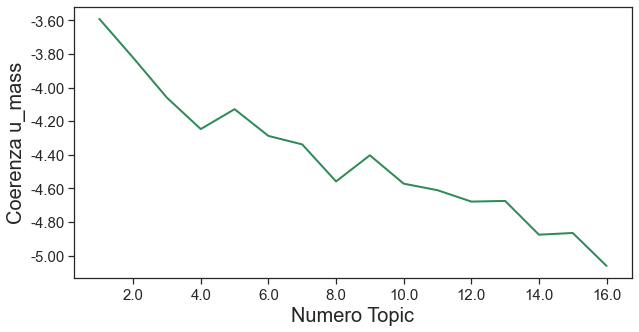

In [545]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('white', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

l=sns.lineplot(x=n_topics,y=cmu_topics, color = 'seagreen', linewidth=2)
l.set_xticklabels(l.get_xticks(), fontsize=15)
l.set_ylabel('Coerenza u_mass',fontsize= 20)
l.set_xlabel('Numero Topic',fontsize= 20)
l.set_yticklabels(['{:,.2f}'.format(y) for y in l.get_yticks()] ,fontsize=15,);
l.tick_params(labelsize=15)

#### **Visualize TOPICS**

In [135]:
lda_display6 = pyLDAvis.gensim_models.prepare(lda_model_final_6, corpus, dictionary)
pyLDAvis.display(lda_display6)

In [136]:
lda_display7 = pyLDAvis.gensim_models.prepare(lda_model_final_7 , corpus, dictionary)
pyLDAvis.display(lda_display7)

In [137]:
lda_display8 = pyLDAvis.gensim_models.prepare(lda_model_final_8 , corpus, dictionary)
pyLDAvis.display(lda_display8)

In [533]:
lda_display9 = pyLDAvis.gensim_models.prepare(lda_model_final_9 , corpus, dictionary)
pyLDAvis.display(lda_display9)

In [139]:
lda_display10 = pyLDAvis.gensim_models.prepare(lda_model_final_10 , corpus, dictionary)
pyLDAvis.display(lda_display10)

In [140]:
lda_display11 = pyLDAvis.gensim_models.prepare(lda_model_final_11 , corpus, dictionary)
pyLDAvis.display(lda_display11)

In [141]:
lda_display12 = pyLDAvis.gensim_models.prepare(lda_model_final_12 , corpus, dictionary)
pyLDAvis.display(lda_display12)

In [526]:
lda_display13 = pyLDAvis.gensim_models.prepare(lda_model_final_13 , corpus, dictionary)
pyLDAvis.display(lda_display13)

In [631]:
pyLDAvis.gensim_models.prepare(lda_model_final_13, corpus, dictionary, sort_topics=False, mds='mmds').to_dict()['mdsDat']['Freq']

[6.655294712865095,
 5.9995866788466365,
 8.775537075953894,
 9.849667001702592,
 8.079653648119328,
 6.487077448206639,
 7.399942099800957,
 7.753194518749849,
 6.367267151635933,
 9.880073050878407,
 7.90255557875844,
 8.030595671066562,
 6.819555363415654]

In [632]:
somma = [6.655294712865095,
 5.9995866788466365,
 8.775537075953894,
 9.849667001702592,
 8.079653648119328,
 6.487077448206639,
 7.399942099800957,
 7.753194518749849,
 6.367267151635933,
 9.880073050878407,
 7.90255557875844,
 8.030595671066562,
 6.819555363415654]

sum(somma)

100.0

In [633]:
df_python.describe()

id         score    view_count  answer_count  \
count  2.064870e+06  2.064870e+06  2.064870e+06  2.064870e+06   
mean   4.714924e+07  2.296740e+00  2.906132e+03  1.410159e+00   
std    1.861554e+07  2.892988e+01  3.215387e+04  1.354347e+00   
min    3.370000e+02 -6.400000e+01  2.000000e+00  0.000000e+00   
25%    3.446578e+07  0.000000e+00  6.300000e+01  1.000000e+00   
50%    5.158096e+07  0.000000e+00  2.210000e+02  1.000000e+00   
75%    6.266475e+07  1.000000e+00  9.940000e+02  2.000000e+00   
max    7.136786e+07  1.188000e+04  6.505358e+06  1.910000e+02   

       accepted_answer_id  comment_count  post_creation_year  
count        1.060052e+06   2.064870e+06        2.064870e+06  
mean         4.411916e+07   2.024341e+00        2.017520e+03  
std          1.944015e+07   2.552321e+00        3.018559e+00  
min          3.420000e+02   0.000000e+00        2.008000e+03  
25%          2.954056e+07   0.000000e+00        2.015000e+03  
50%          4.817526e+07   1.000000e+00        2.018000e+03  
75%          6.070392e+07   3.000000e+00        2.020000e+03  
max          7.136786e+07   6.600000e+01        2.022000e+03

In [532]:
#vis_data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(lda_display13, 'lda_display13.html')

In [143]:
lda_display14 = pyLDAvis.gensim_models.prepare(lda_model_final_14 , corpus, dictionary)
pyLDAvis.display(lda_display14)

In [144]:
lda_display15 = pyLDAvis.gensim_models.prepare(lda_model_final_15 , corpus, dictionary)
pyLDAvis.display(lda_display15)